# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B005ZBZLT4                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ESG  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B005ZBZLT4        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ESG           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBEV0   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B001ATMQK2  undertheshrine "undertheshrine"  1296691200   

       Score                                               Text  COUNT(*)  
80638      5  I bought this 6 pack because for the price tha...         5

In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
prepr_rev = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    prepr_rev.append(sentance.strip())

100%|██████████| 87773/87773 [00:46<00:00, 1888.56it/s]


In [24]:
prepr_rev[1500]

'way hot blood took bite jig lol'

In [25]:
print(len(prepr_rev))
final.shape

87773


(87773, 10)

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [26]:
## Similartly you can do preprocessing for review summary also.
## Similartly you can do preprocessing for review summary also.
preprocessed_summary = []
# tqdm is for printing the status bar
for summary in tqdm(final['Summary'].values):
    summary = re.sub(r"http\S+", "", summary) # remove urls from text python: https://stackoverflow.com/a/40823105/4084039 
    summary = BeautifulSoup(summary, 'lxml').get_text() # https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
    summary = decontracted(summary)
    summary = re.sub("\S*\d\S*", "", summary).strip() #remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
    summary = re.sub('[^A-Za-z]+', ' ', summary) #remove spacial character: https://stackoverflow.com/a/5843547/4084039
    # https://gist.github.com/sebleier/554280
    summary = ' '.join(e.lower() for e in summary.split() if e.lower() not in stopwords)
    preprocessed_summary.append(summary.strip())

100%|██████████| 87773/87773 [00:25<00:00, 3456.24it/s]


In [27]:
prepr_rev = [i + ' ' + j for i, j in zip(prepr_rev,preprocessed_summary)] 
print(prepr_rev[1500])

way hot blood took bite jig lol hot stuff


In [28]:
final ['CleanText']= prepr_rev
final.head(5)

Id   ProductId          UserId        ProfileName  \
22620  24750  2734888454  A13ISQV0U9GZIC          Sandikaye   
22621  24751  2734888454  A1C298ITT645B6  Hugh G. Pritchard   
70677  76870  B00002N8SM  A19Q006CSFT011           Arlielle   
70676  76869  B00002N8SM  A1FYH4S02BW7FN           wonderer   
70675  76868  B00002N8SM   AUE8TB5VHS6ZV      eyeofthestorm   

       HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
22620                     1                       1      0  1192060800   
22621                     0                       0      1  1195948800   
70677                     0                       0      0  1288396800   
70676                     0                       0      0  1290038400   
70675                     0                       0      0  1306972800   

                                       Summary  \
22620                            made in china   
22621                        Dog Lover Delites   
70677                  only one fruitfly stuck   
70676  Doesn't work!! Don't waste your money!!   
70675                            A big rip off   

                                                    Text  \
22620  My dogs loves this chicken but its a product f...   
22621  Our dogs just love them.  I saw them in a pet ...   
70677  I had an infestation of fruitflies, they were ...   
70676  Worst product I have gotten in long time. Woul...   
70675  I wish I'd read the reviews before making this...   

                                               CleanText  
22620  dogs loves chicken product china wont buying a...  
22621  dogs love saw pet store tag attached regarding...  
70677  infestation fruitflies literally everywhere fl...  
70676  worst product gotten long time would rate no s...  
70675  wish would read reviews making purchase basica...

# [4] Featurization

## [4.1] BAG OF WORDS

In [29]:
##Sorting data for Time Based Splitting
final = final.sort_values('Time',axis= 0,inplace = False , na_position = 'last',ascending = True)
x = final['CleanText'].values
x = x[:50000]
print(x.shape)
 

(50000,)


In [30]:
#BoW
count_vect = CountVectorizer(min_df=10, max_features=500) #in scikit-learn
count_vect.fit(x)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

bow = count_vect.transform(x)
print("the type of count vectorizer ",type(bow))
print("the shape of out text BOW vectorizer ",bow.get_shape())
print("the number of unique words ", bow.get_shape()[1])

some feature names  ['able', 'absolutely', 'acid', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almonds', 'almost']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (50000, 500)
the number of unique words  500


## [4.2] Bi-Grams and n-Grams.

In [31]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(x)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (50000, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [32]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(x)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(x)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able buy', 'able chew', 'able drink']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (50000, 31657)
the number of unique words including both unigrams and bigrams  31657


## [4.4] Word2Vec

In [33]:
list_of_sent=[]
for sent in x:
    list_of_sent.append(sent.split())   
    
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))
    
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))


[('terrific', 0.8330832719802856), ('fantastic', 0.820777177810669), ('good', 0.8076774477958679), ('excellent', 0.8041877746582031), ('awesome', 0.8007186651229858), ('wonderful', 0.7418226599693298), ('perfect', 0.7386773824691772), ('fabulous', 0.7119407653808594), ('nice', 0.6741513013839722), ('amazing', 0.6705402135848999)]
[('best', 0.7245403528213501), ('greatest', 0.7173395156860352), ('coolest', 0.6970437169075012), ('closest', 0.6905653476715088), ('tastiest', 0.6829025745391846), ('weakest', 0.650667667388916), ('disgusting', 0.6475515365600586), ('horrible', 0.6332492828369141), ('softest', 0.6053248047828674), ('toughest', 0.5873352885246277)]
number of words that occured minimum 5 times  13886


In [34]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  13886
sample words  ['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'within', 'days', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'driving', 'crazy', 'consider', 'buying', 'one', 'caution', 'surface', 'sticky', 'try', 'avoid', 'touching', 'sure', 'death', 'really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'made', 'two', 'thumbs', 'great', 'received', 'shipment', 'could', 'hardly']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [35]:
sent_vectors = []; 
for sent in tqdm(list_of_sent):
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)  
    
sent_vectors = np.array(sent_vectors)

print(sent_vectors.shape)
print(sent_vectors[0])  

100%|██████████| 50000/50000 [02:24<00:00, 344.86it/s]


(50000, 50)
[ 0.08148152 -0.07302814 -0.14164004  0.12298822  0.13309439 -0.36973574
  0.03244577 -0.35948489  0.09700029  0.22092107  0.15776166 -0.27683736
  0.10414379  0.41484572  0.26685561 -0.49900008  0.4725336   0.08330678
  0.10152018 -0.54792958  0.30265878 -0.40084445 -0.56797432  0.3785896
 -0.2813673   0.37153642 -0.51429368 -0.52691988  0.11484049  0.35903934
  0.22011637 -0.15908686  0.07764841  0.18592272  0.04054431  0.73765682
 -0.13231639  0.09596386 -0.73765805  0.1683076   0.0949332   0.08876026
  0.04699773 -0.30760158 -0.07468644  0.23636343  0.20477603 -0.35697004
  0.07523434  0.87214997]


#### [4.4.1.2] TFIDF weighted W2v

In [36]:
# compute TFIDF Weighted Word2Vec  .

tf_idf_vect = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tf_idf1 = tf_idf_vect.fit_transform(x)
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

# tfidf words/col-names
tfidf_feat = tf_idf_vect.get_feature_names()

# compute TFIDF Weighted Word2Vec for X_test .
tfidf_sent_vec = []; 
row=0;
for sent in tqdm(list_of_sent): 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vec.append(sent_vec)
    
tfidf_sent_vec = np.array(tfidf_sent_vec)
print(tfidf_sent_vec.shape)
print(tfidf_sent_vec[0])

100%|██████████| 50000/50000 [36:49<00:00, 21.21it/s]  


(50000, 50)
[ 0.23326281 -0.01027238  0.0666112   0.28477189  0.137612   -0.33829764
  0.00231863 -0.31298191 -0.01012428  0.1594723   0.28274033 -0.31588166
  0.18162142  0.27471741  0.11477455 -0.24703551  0.44998902  0.00520531
  0.06148347 -0.38545779  0.06459191 -0.44736568 -0.56471656  0.48445503
 -0.35246977  0.36311095 -0.45617994 -0.39031374 -0.11077728  0.04435709
  0.08993178 -0.0298072   0.14902198  0.19705657  0.06999817  0.78314645
 -0.10624039 -0.0413627  -0.56380057  0.07071167 -0.00320268  0.081129
 -0.13712195 -0.53835695 -0.14324974  0.10587505  0.14483673 -0.38876992
  0.03656375  0.77178045]


# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

In [37]:
# Please write all the code with proper documentation
from sklearn.cluster import KMeans

k_val = list(range(2, 50,5))
inertia_bow = []
for i in tqdm(k_val):
    km = KMeans(n_clusters=i)
    km.fit(bow)
    inertia_bow.append(km.inertia_)

100%|██████████| 10/10 [1:53:52<00:00, 764.09s/it]


In [38]:
plt.plot(k_val,inertia_bow,'g')
plt.grid(True)
plt.title("K vs Inertia \n",size=20)
plt.xlabel("K",size=20)
plt.ylabel("Inertia",size=20)
plt.show();

In [39]:
optimal_k = 7
km= KMeans(n_clusters=optimal_k).fit(bow)

In [40]:
cluster = [ [] for i in range(optimal_k) ]   
for i in range(km.labels_.shape[0]):
    cluster[km.labels_[i]].append(x[i])

### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

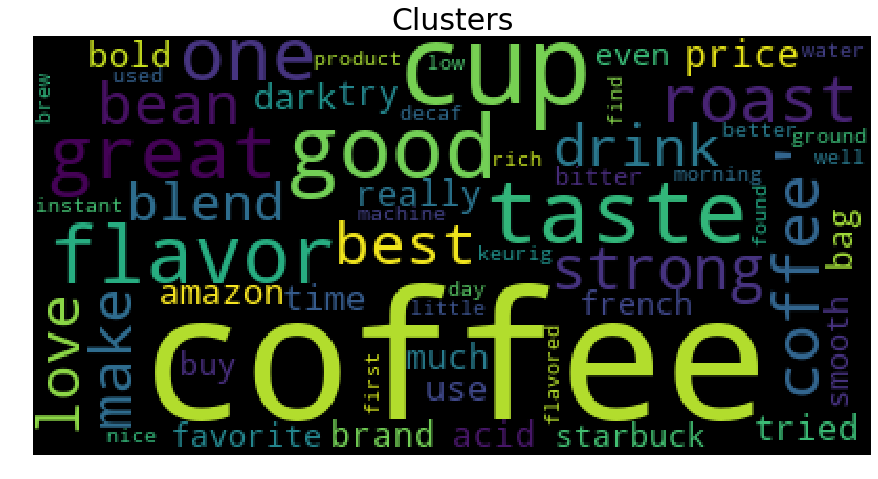

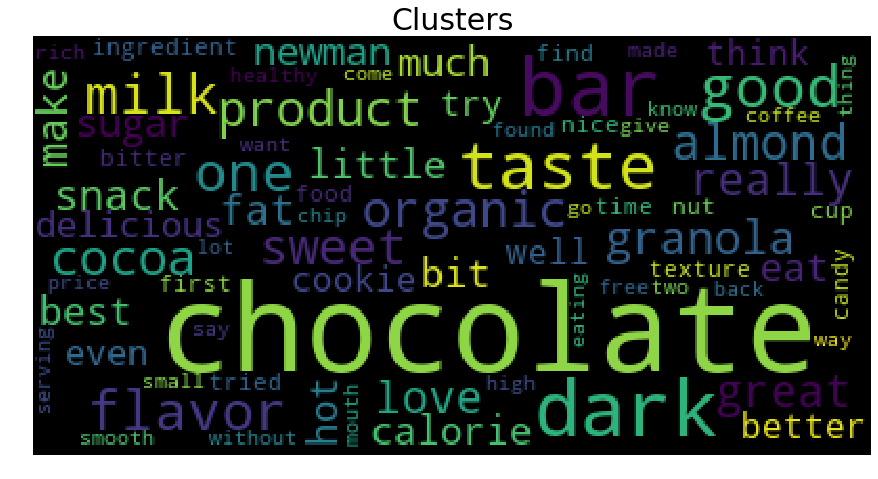

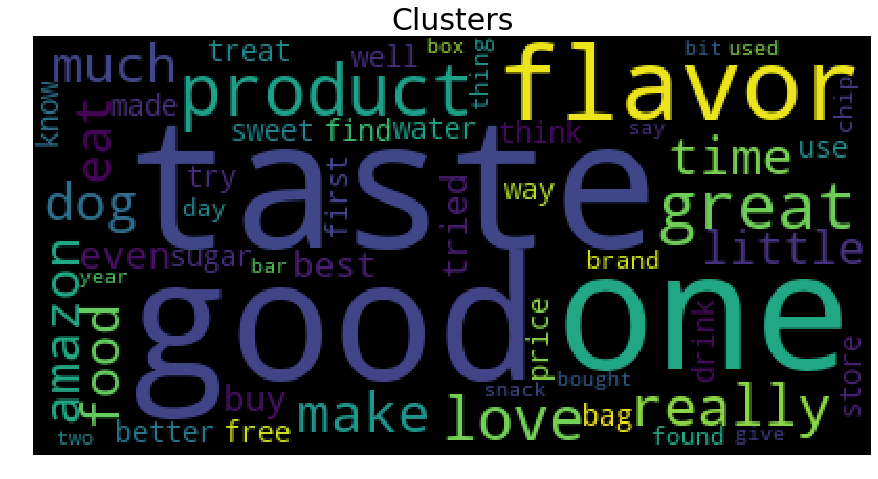

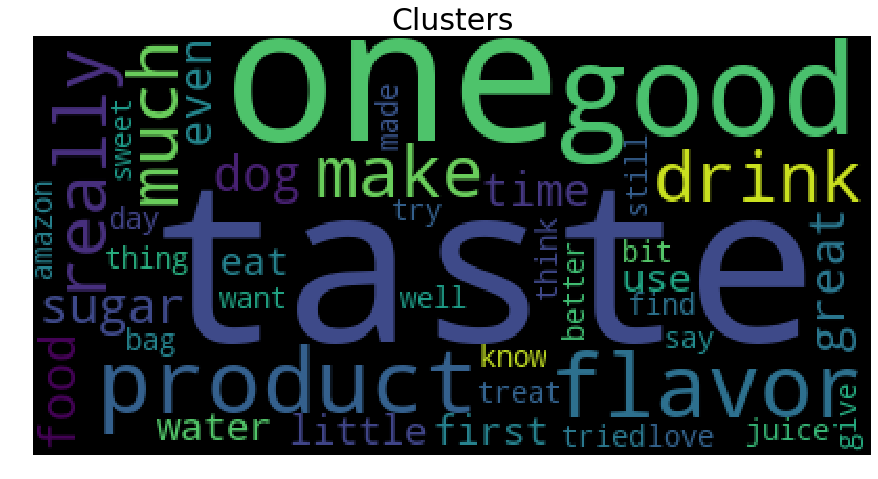

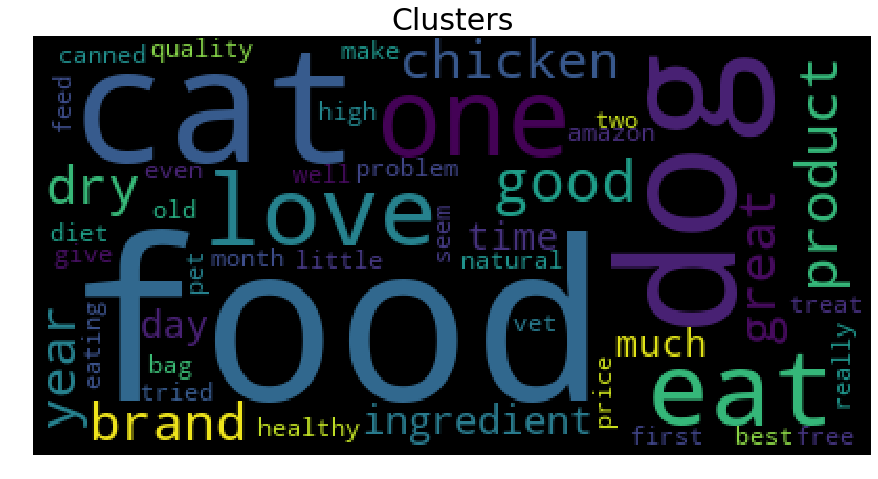

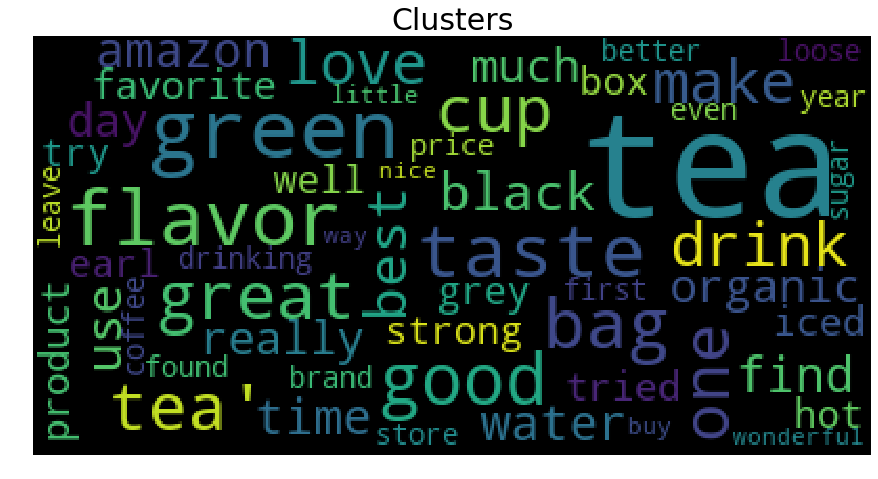

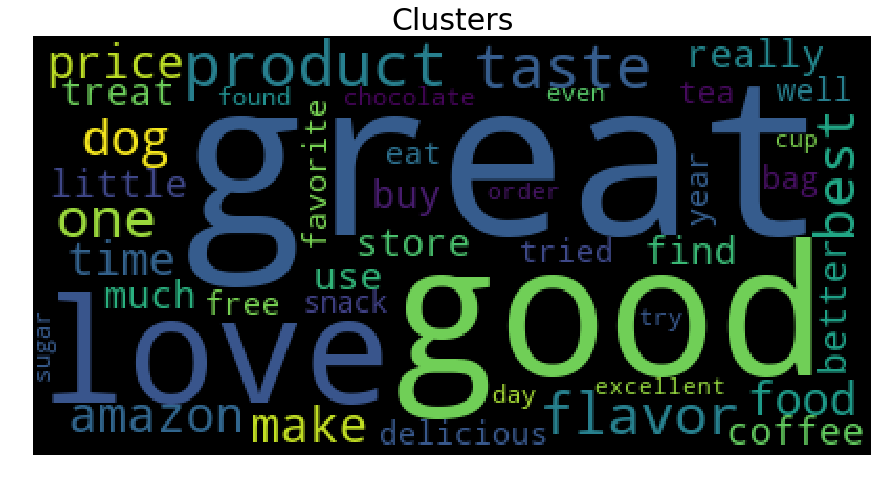

In [41]:
# Please write all the code with proper documentation
from wordcloud import WordCloud

def cloud(clusters):
    wordcloud = WordCloud(collocations=False, background_color ='black', 
                    min_font_size = 10).generate(str(list(clusters)))
    plt.figure(figsize = (12,12), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title("Clusters",size= 30,)
    plt.show() 
for cls in cluster:
    cloud(cls)

**Observation:**

<font color='blue'>7 Clusters =</font>
  
The clusters are about,
1. This cluster is about tea, coffee flavor related words.
2. This cluster is about chocolate and tea related words..
3. This cluster is about product related words like how good or great it is
4. This cluster is about product related words like how good or great it is
5. This cluster is probably about cat food related...
6. This cluster is about tea or green tea, black tea related words.
7. This cluster is about product related words like how good or great it is

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

In [42]:
# Please write all the code with proper documentation
k_val = list(range(2, 50,5))
inertia_tfidf = []
for i in tqdm(k_val):
    km = KMeans(n_clusters=i)
    km.fit(final_tf_idf)
    inertia_tfidf.append(km.inertia_)

100%|██████████| 10/10 [5:11:11<00:00, 2002.70s/it] 


In [43]:
plt.plot(k_val,inertia_tfidf,'g')
plt.grid(True)
plt.title("K vs Inertia \n",size=20)
plt.xlabel("K",size=20)
plt.ylabel("Inertia",size=20)
plt.show();

### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

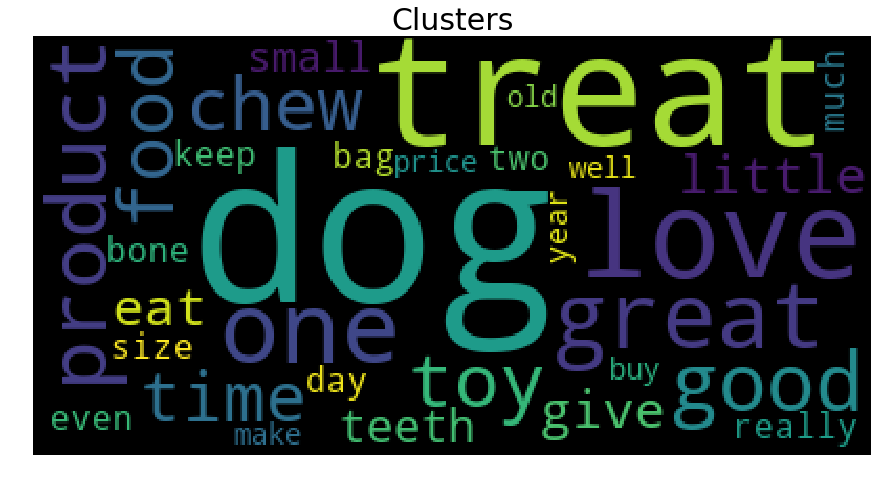

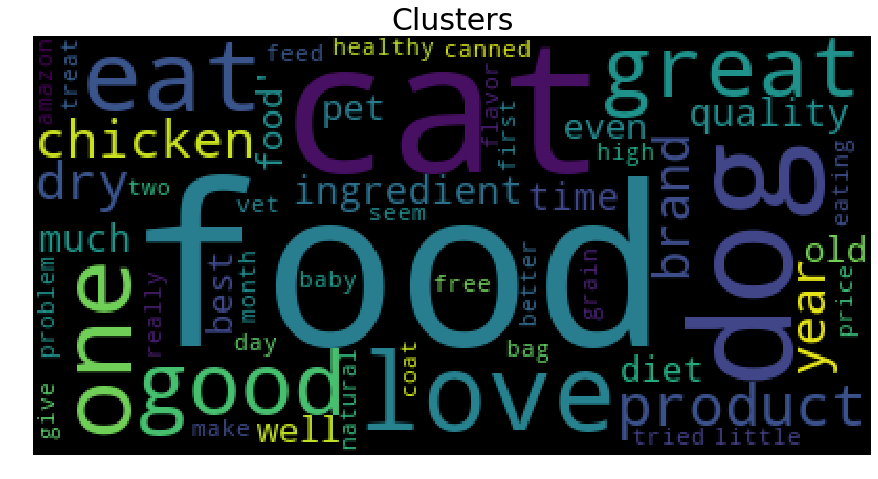

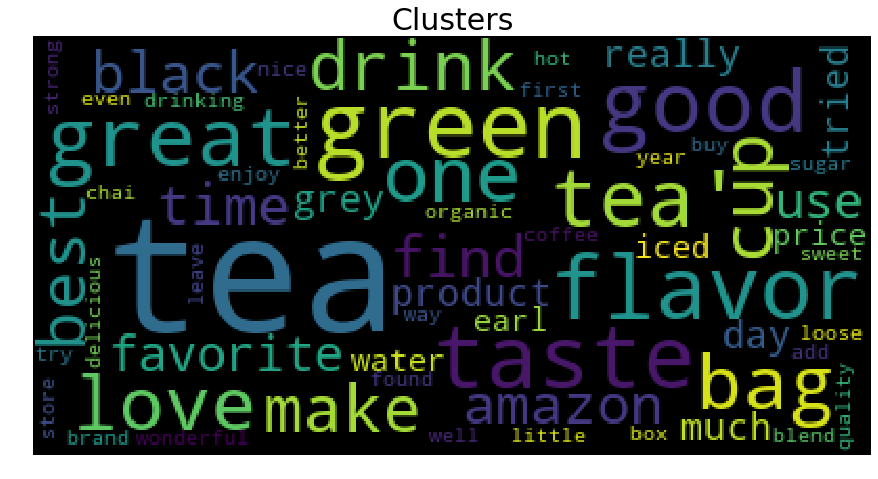

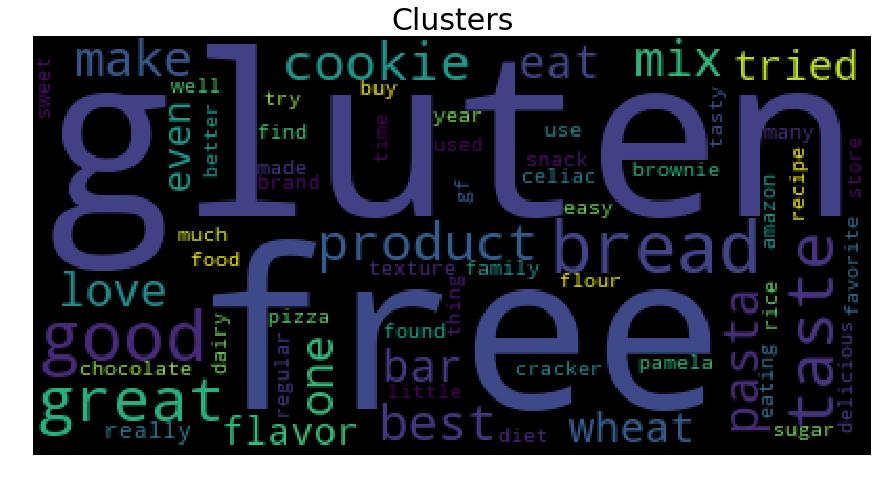

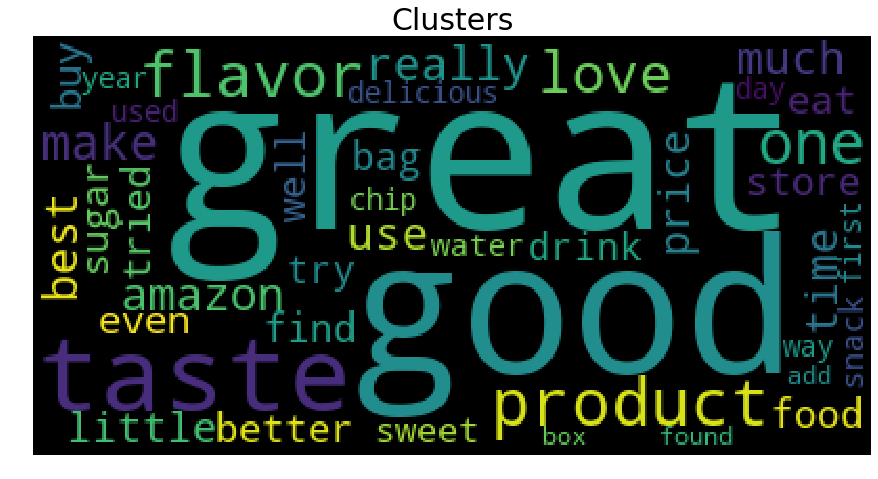

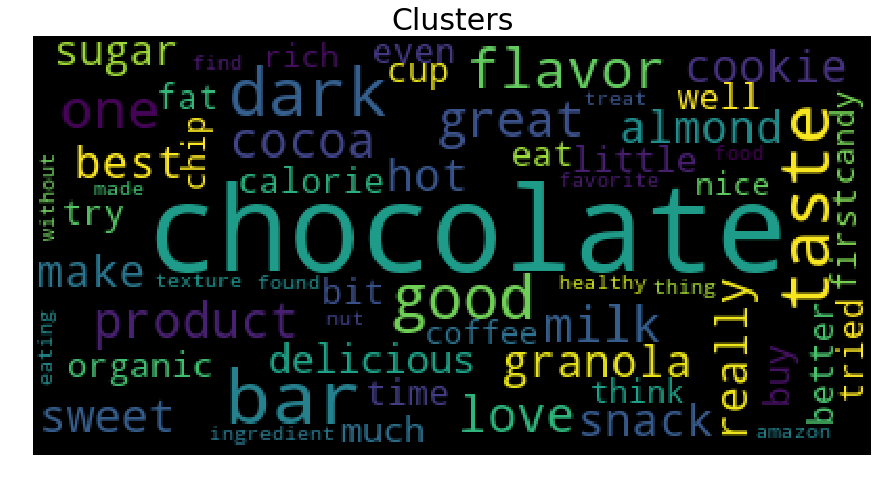

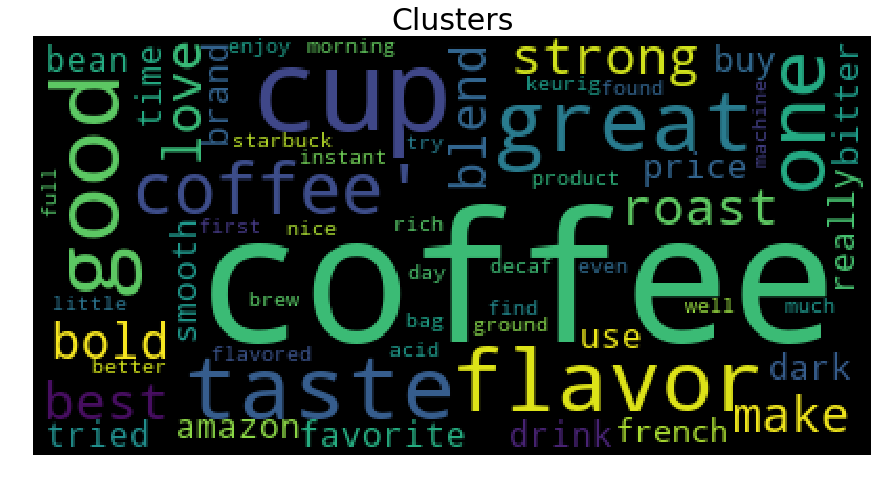

In [44]:
# Please write all the code with proper documentation
optimal_k = 7
km = KMeans(n_clusters=optimal_k).fit(final_tf_idf)
clust_tfidf = [ [] for i in range(optimal_k) ]   
for i in range(km.labels_.shape[0]):
    clust_tfidf[km.labels_[i]].append(x[i])
for cls in clust_tfidf:
    cloud(cls)

**Observation:**

<font color='blue'> 7 Clusters =</font>
  
The clusters are about,
1. This cluster is probably about dog food related...
2. This cluster is probably about cat food related...
3. This cluster is about tea or green tea, black tea related words.
4. This cluster is about related Gluten, 'cookie', 'bread', 'brownie' and product related words like how good or great it is.
5. This cluster is about product related words like how good or great it is
6. This cluster is about chocolate and tea related words..
7. This cluster is about tea, coffee, black coffee, flavour related words.

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

In [45]:
# Please write all the code with proper documentation
k_val = list(range(2, 50,5))
inertia_wtv = []
for i in tqdm(k_val):
    km = KMeans(n_clusters=i)
    km.fit(sent_vectors)
    inertia_wtv.append(km.inertia_)

100%|██████████| 10/10 [04:01<00:00, 36.13s/it]


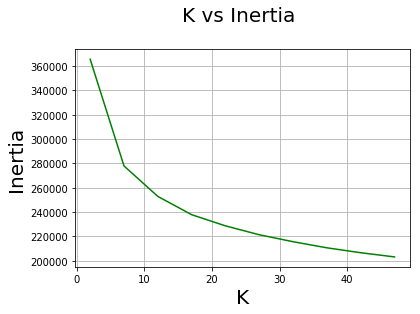

In [46]:
plt.plot(k_val,inertia_wtv,'g')
plt.grid(True)
plt.title("K vs Inertia \n",size=20)
plt.xlabel("K",size=20)
plt.ylabel("Inertia",size=20)
plt.show();

### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

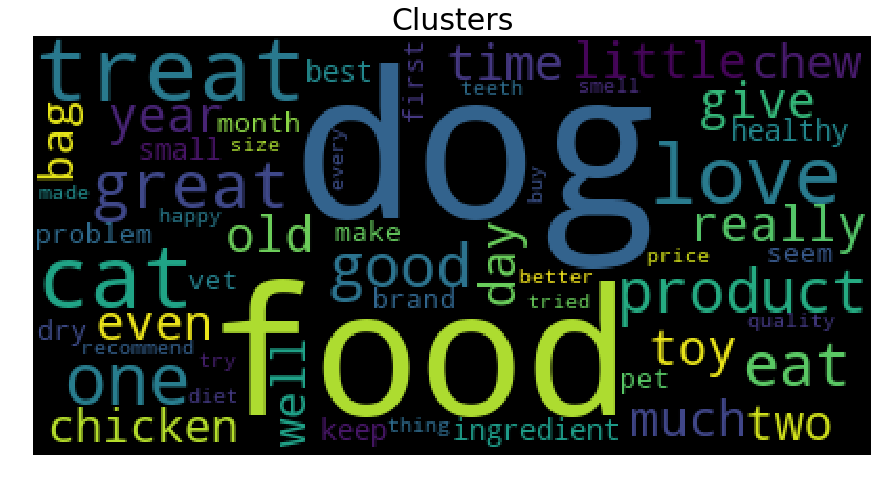

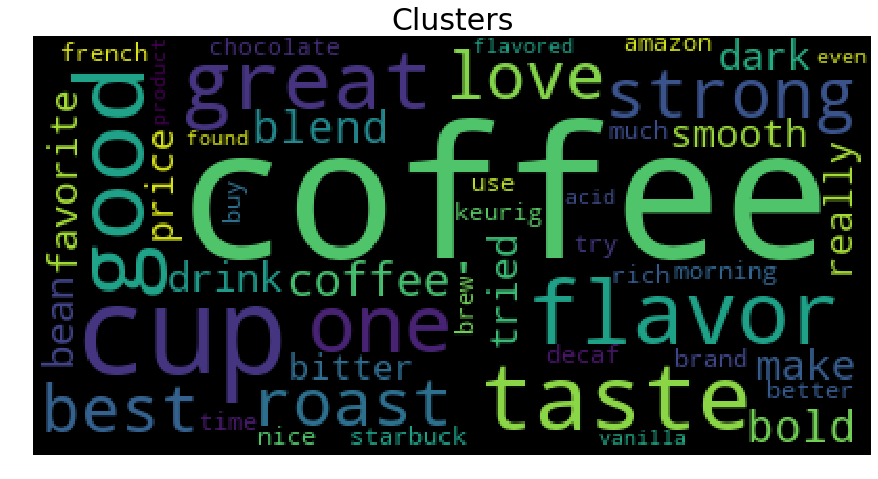

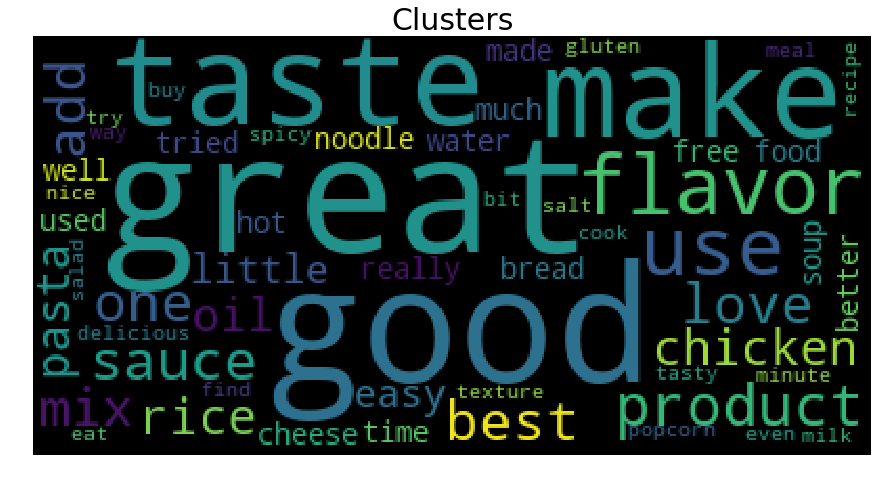

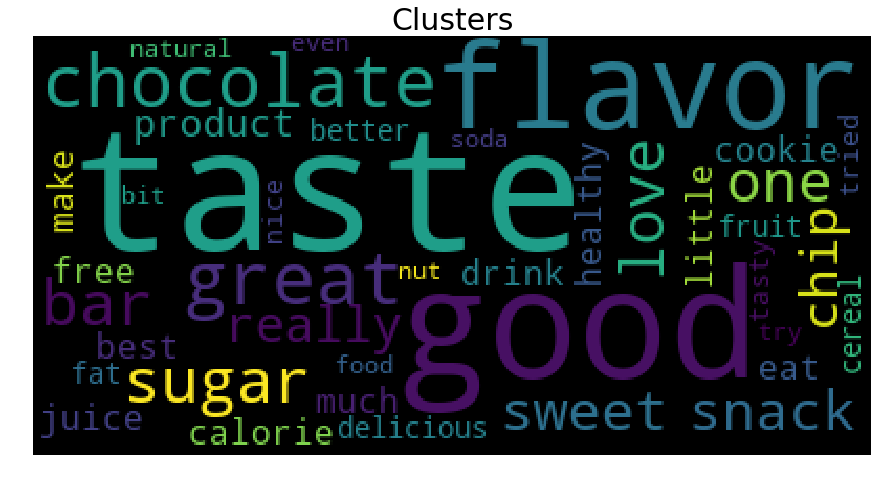

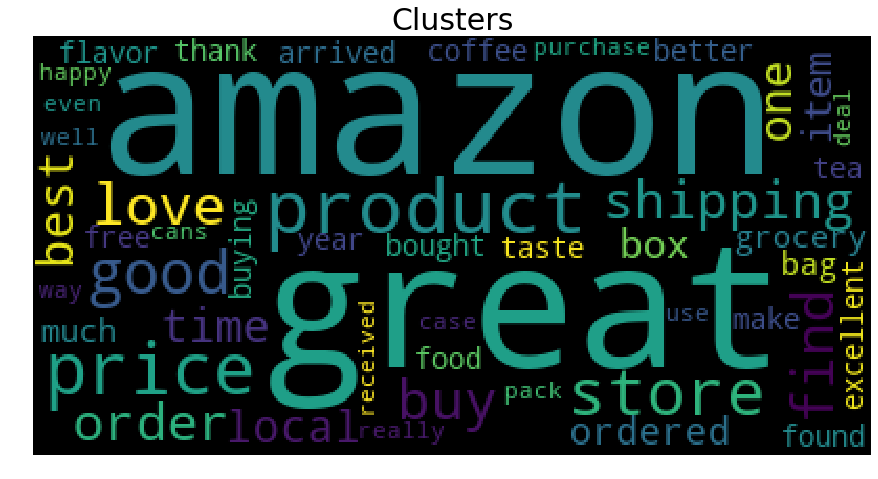

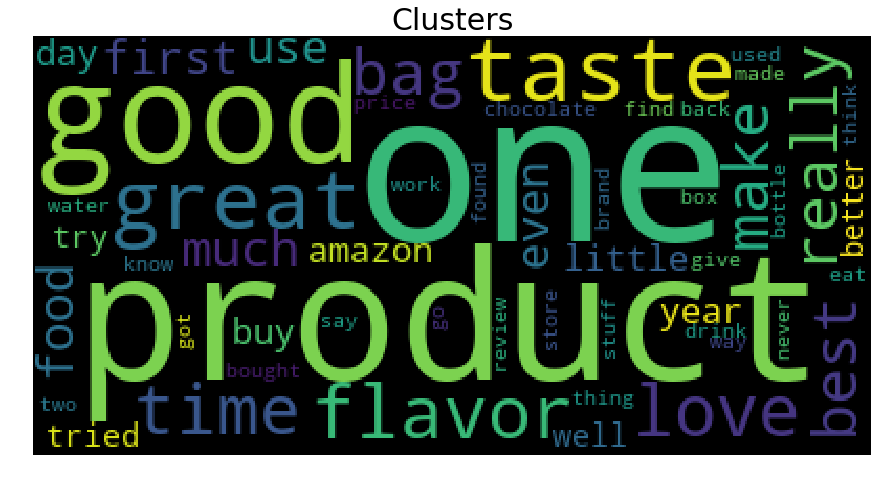

In [47]:
# Please write all the code with proper documentation
optimal_k = 7
km = KMeans(n_clusters=optimal_k).fit(sent_vectors)
clust_wtv = [ [] for i in range(optimal_k) ]   
for i in range(km.labels_.shape[0]):
    clust_wtv[km.labels_[i]].append(x[i])
for cls in clust_wtv:
    cloud(cls)

**Observation:**

<font color='blue'>7 Clusters =</font>
  
The clusters are about,
1. This cluster is probably about dog food related...
2. This cluster is about coffee related words.
3. This cluster is about product related words like how good or great it is
4. This cluster is about green tea and flavour.
5. This cluster is about chocolate flavour related words..
6. This cluster is about Amazon product price
7. This cluster is about product price related words and product how flavor, good or great it is

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [48]:
# Please write all the code with proper documentation
k_val = list(range(2, 50,5))
inertia_tfidfwtv = []
for i in tqdm(k_val):
    km = KMeans(n_clusters=i)
    km.fit(tfidf_sent_vec)
    inertia_tfidfwtv.append(km.inertia_)

100%|██████████| 10/10 [03:56<00:00, 35.00s/it]


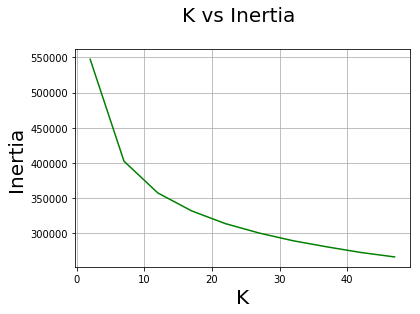

In [49]:
plt.plot(k_val,inertia_tfidfwtv,'g')
plt.grid(True)
plt.title("K vs Inertia \n",size=20)
plt.xlabel("K",size=20)
plt.ylabel("Inertia",size=20)
plt.show();

### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

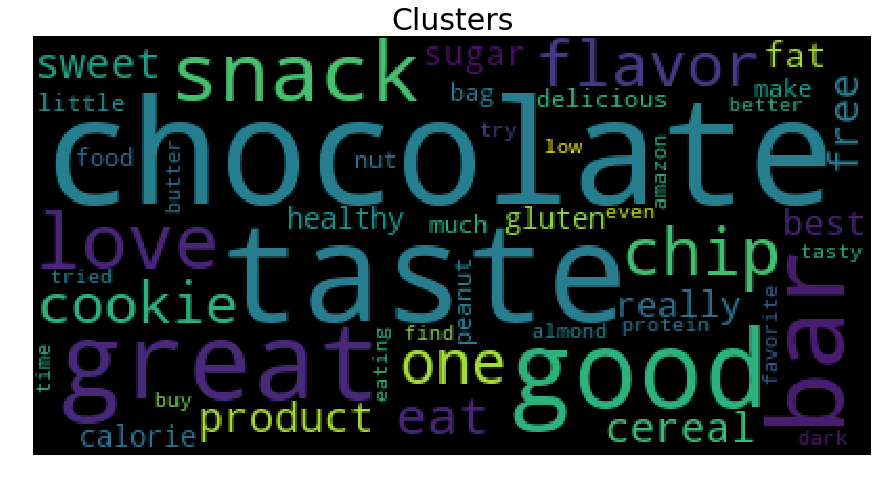

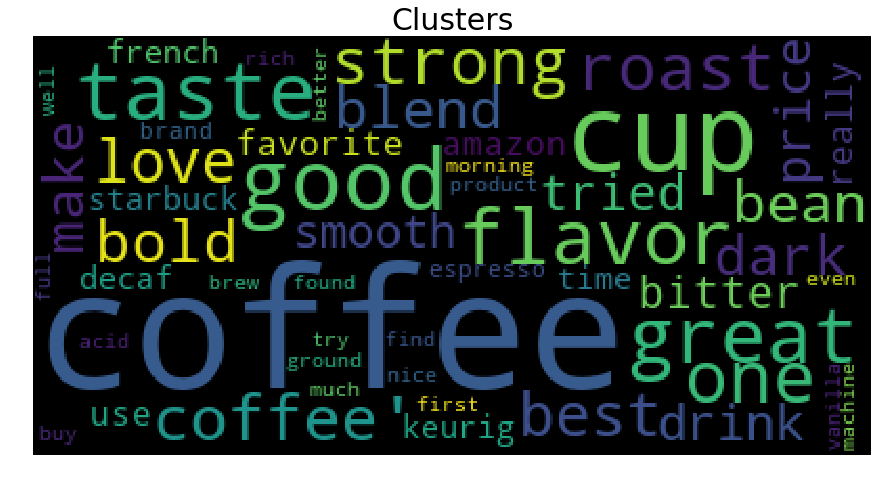

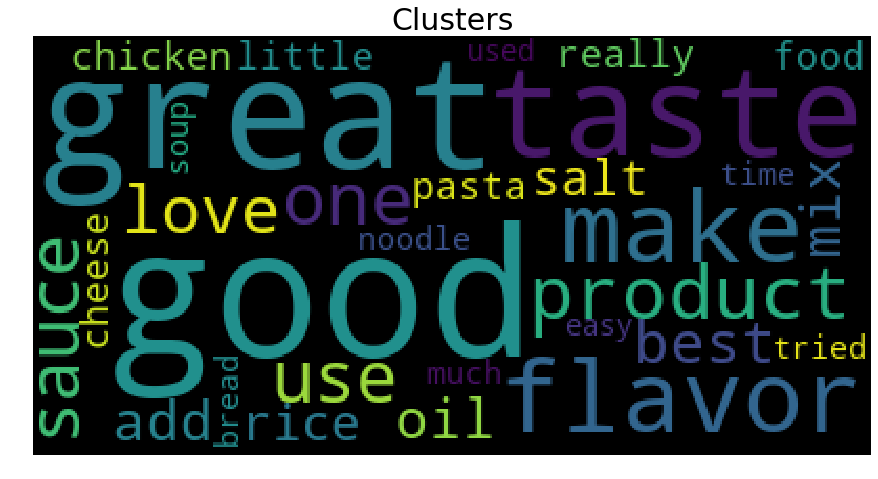

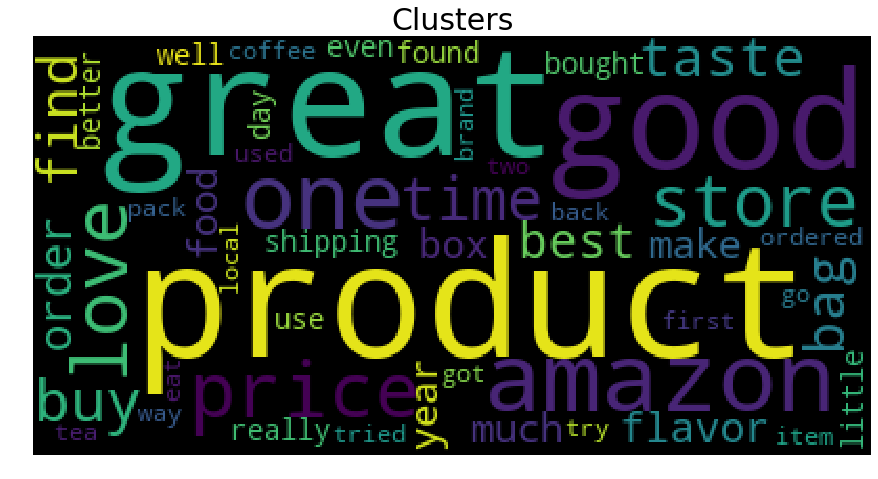

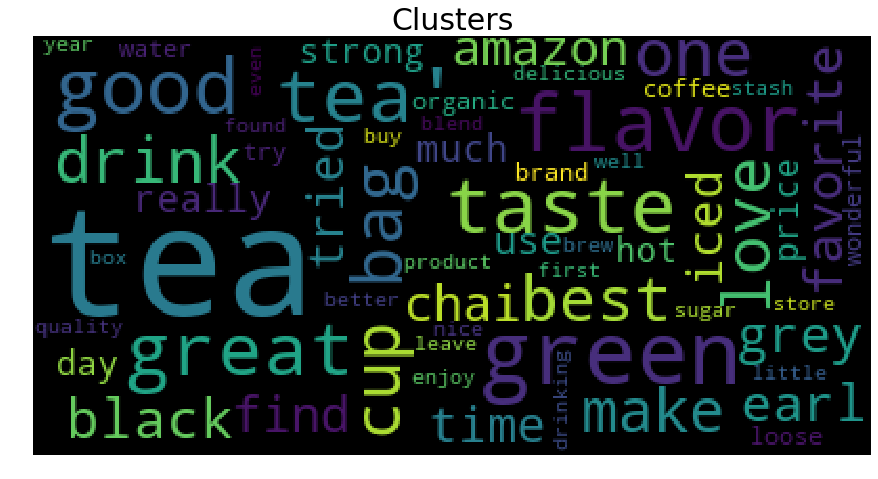

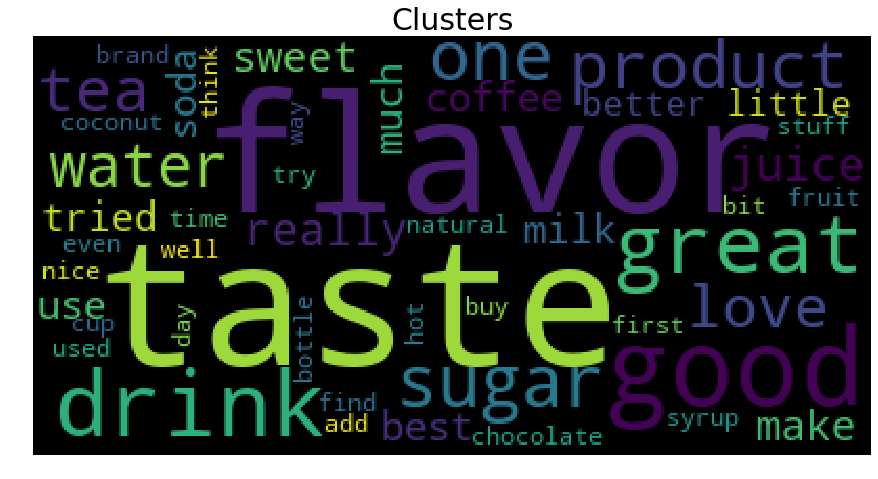

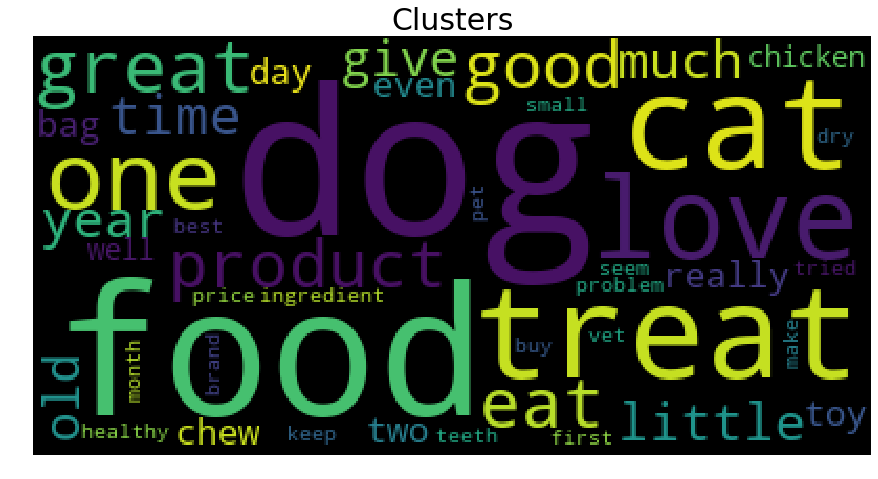

In [50]:
# Please write all the code with proper documentation
optimal_k = 7
km = KMeans(n_clusters=optimal_k).fit(tfidf_sent_vec)
clust_tfidfwtv = [ [] for i in range(optimal_k) ]   
for i in range(km.labels_.shape[0]):
    clust_tfidfwtv[km.labels_[i]].append(x[i])
for cls in clust_tfidfwtv:
    cloud(cls)

**Observation:**

<font color='blue'>7 Clusters =</font>
  
The clusters are about,
1. This cluster is about chocolate teste related words..
2. This cluster is about coffee related words.
3. This cluster is about product related words like how good or great it is probably rice.
4. This cluster is about product price.
5. This cluster is about green tea and tea flavor related words..
6. This cluster is related about how product test, flavor and sugar it is .. 
7. This cluster is about dog and cat food related words..

## [5.2] Agglomerative Clustering

In [51]:
final = final.sort_values('Time',axis= 0,inplace = False , na_position = 'last',ascending = True)
X = final['CleanText'].values
X = X[:5000]
print(X.shape)

(5000,)


In [53]:
sent_vect = []
for sent in X :
    sent_vect.append(sent.split())
    
w2v_model=Word2Vec(sent_vect,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

sent_vectors = []; 
for sent in tqdm(sent_vect):
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)  
    
sent_vectors = np.array(sent_vectors)

print(sent_vectors.shape)
print(sent_vectors[0])  

  1%|          | 50/5000 [00:00<00:11, 445.87it/s]

number of words that occured minimum 5 times  4057


100%|██████████| 5000/5000 [00:07<00:00, 664.97it/s]

(5000, 50)
[-0.00760069 -0.09089322  0.15533818  0.10779725 -0.05209951 -0.07904244
  0.08734022  0.11823124  0.23436738  0.45364492  0.30125287  0.01220784
  0.23346649  0.0364662  -0.24251924 -0.46198442  0.36301223 -0.04459204
  0.0790455  -0.07629539  0.14791325 -0.31050146 -0.18083983  0.71637387
  0.09960103  0.16394611 -0.06108867 -0.0233565  -0.18729162 -0.03883281
 -0.23176493 -0.13708705  0.10502247  0.41639693 -0.35457734  0.73027363
  0.24850268 -0.08071178 -0.16190307 -0.28552136 -0.01257494  0.10077228
 -0.13428318 -0.23388689 -0.14627804  0.20034483 -0.1846014  -0.58560636
 -0.55530853  0.5583497 ]


In [55]:
# compute TFIDF Weighted Word2Vec  .

tf_idf_vect = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tf_idf1 = tf_idf_vect.fit_transform(X)
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

# tfidf words/col-names
tfidf_feat = tf_idf_vect.get_feature_names()

# compute TFIDF Weighted Word2Vec for X_test .
tfidf_sent_vec = []; 
row=0;
for sent in tqdm(sent_vect): 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vec.append(sent_vec)
    
tfidf_sent_vec = np.array(tfidf_sent_vec)
print(tfidf_sent_vec.shape)
print(tfidf_sent_vec[0])

100%|██████████| 5000/5000 [00:35<00:00, 139.04it/s]


(5000, 50)
[ 0.00111077 -0.06597052  0.11917079  0.07770393 -0.03967217 -0.05562603
  0.06674531  0.08329167  0.1784354   0.35559975  0.237845    0.01571735
  0.18246759  0.02262233 -0.19593614 -0.35179339  0.2800815  -0.0345565
  0.06629213 -0.06171044  0.11862738 -0.23907156 -0.1365779   0.55600423
  0.07547506  0.13765956 -0.04372886 -0.01457583 -0.14518452 -0.03162793
 -0.18313912 -0.09637264  0.08563385  0.31997556 -0.28026279  0.56660319
  0.19639828 -0.06219436 -0.1189512  -0.22842051 -0.00791616  0.07858272
 -0.09983755 -0.17592655 -0.11113836  0.15337346 -0.14724326 -0.45478518
 -0.43720845  0.42981366]


### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [106]:
# Please write all the code with proper documentation

from sklearn.cluster import AgglomerativeClustering

def all_agg(n_clust):
    print("Clustering",n_clust," Clusters\n")
    agglo = AgglomerativeClustering(n_clusters=n_clust)
    agglo.fit(sent_vectors)
    clust = [ [] for i in range(n_clust) ]   
    for i in range(agglo.labels_.shape[0]):
        clust[agglo.labels_[i]].append(X[i])
    i = 1
    for cls in clust:
        cloud(cls)        

### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

Clustering 3  Clusters



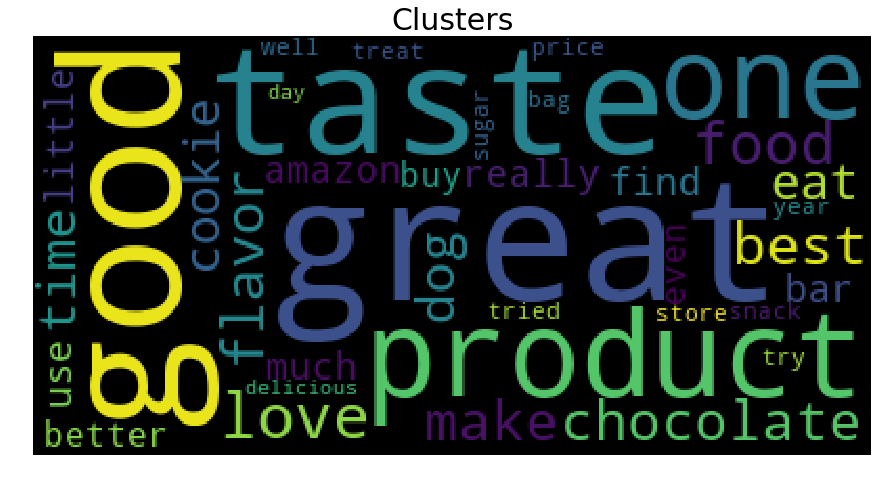

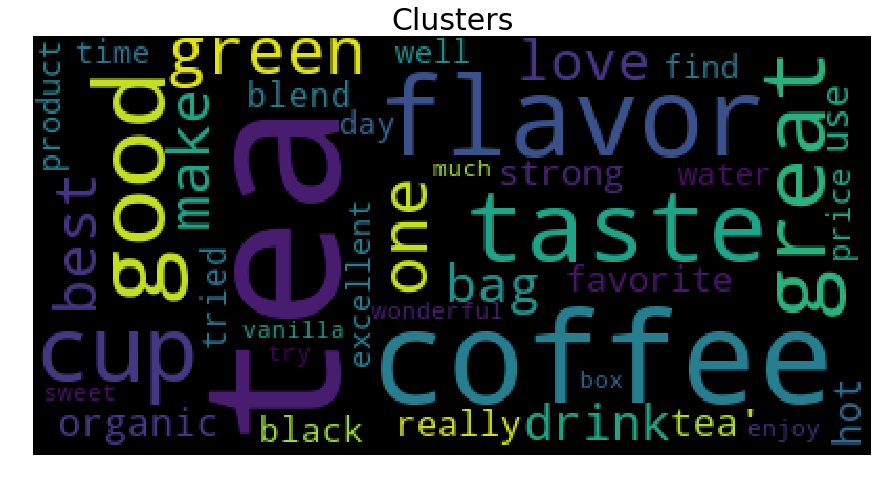

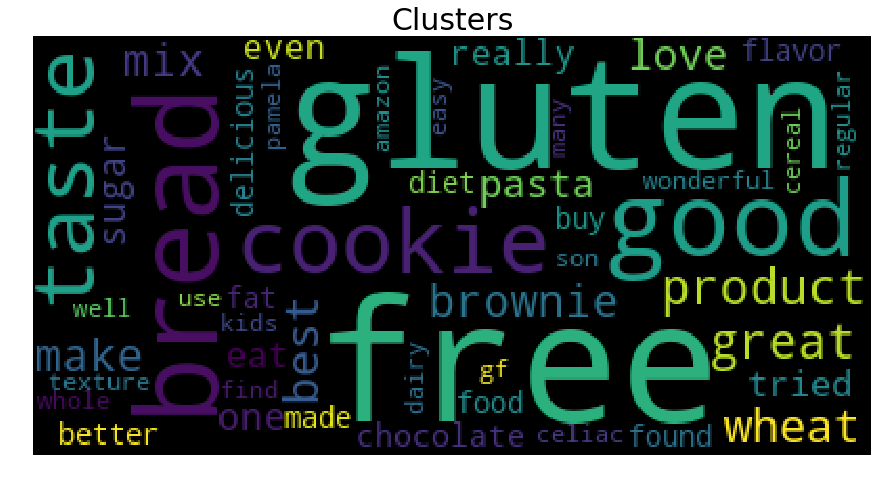

Clustering 5  Clusters



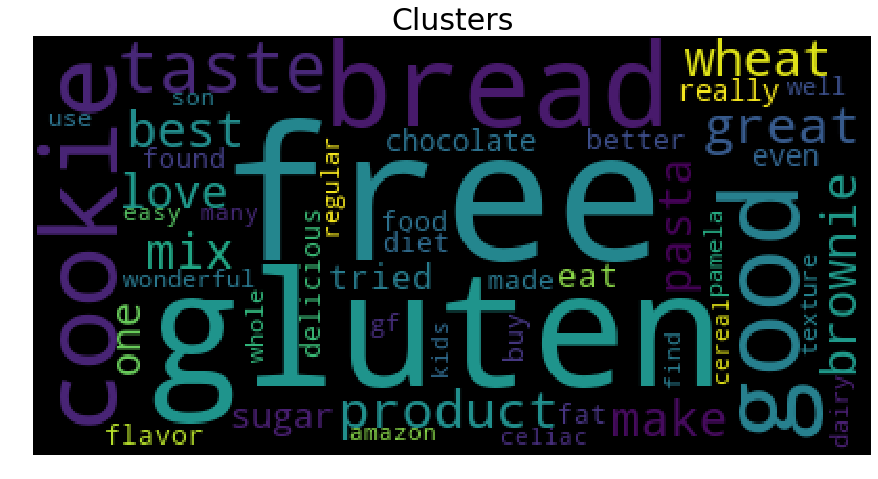

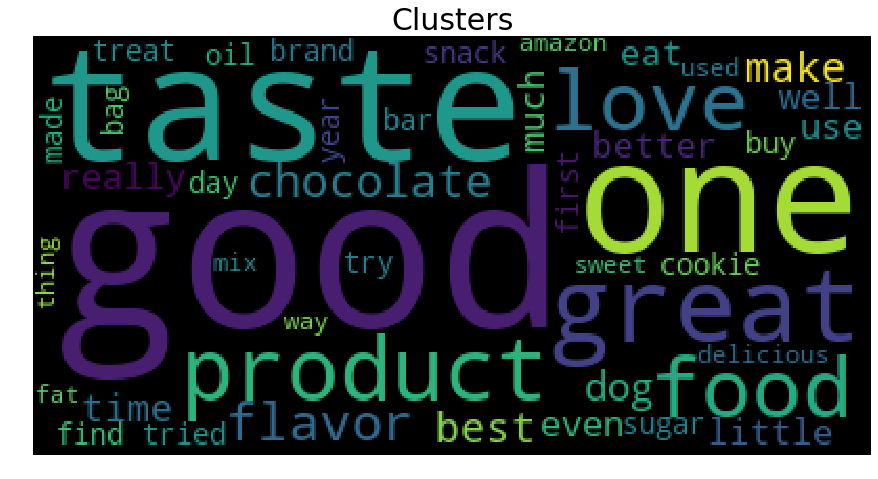

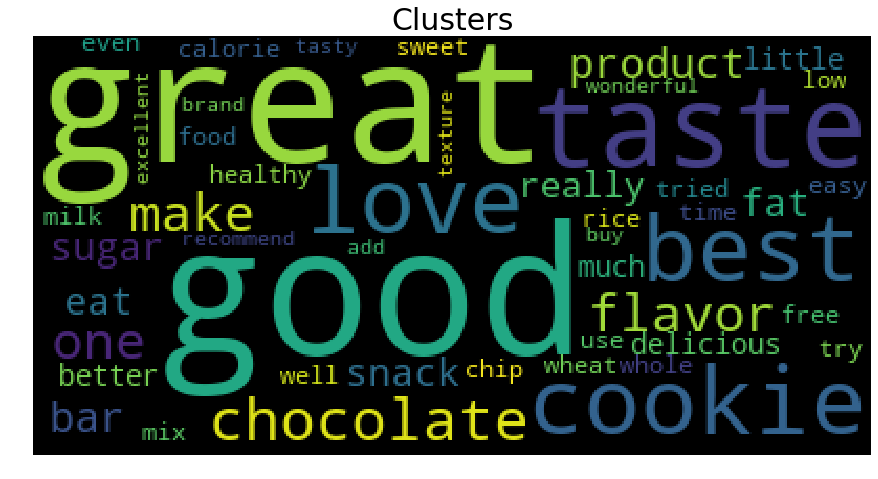

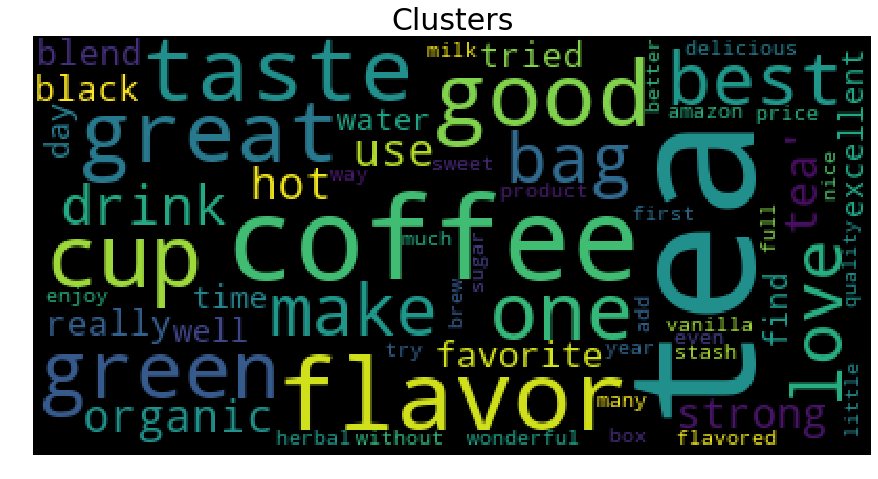

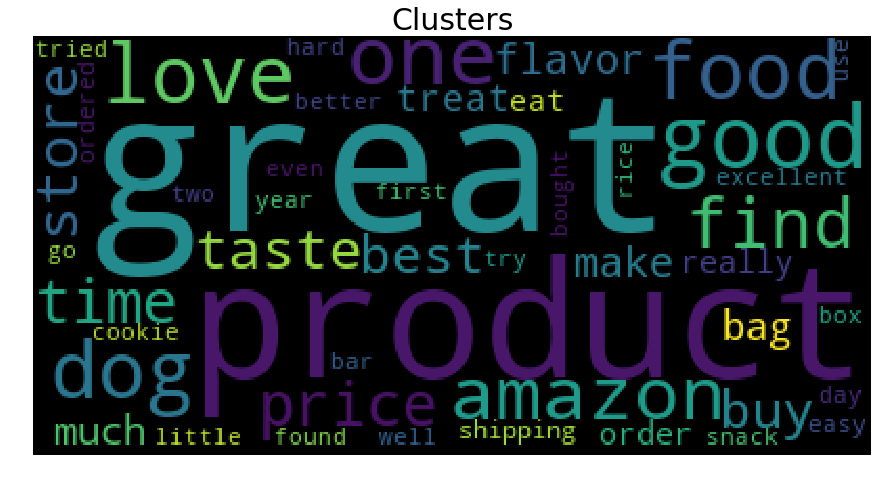

Clustering 7  Clusters



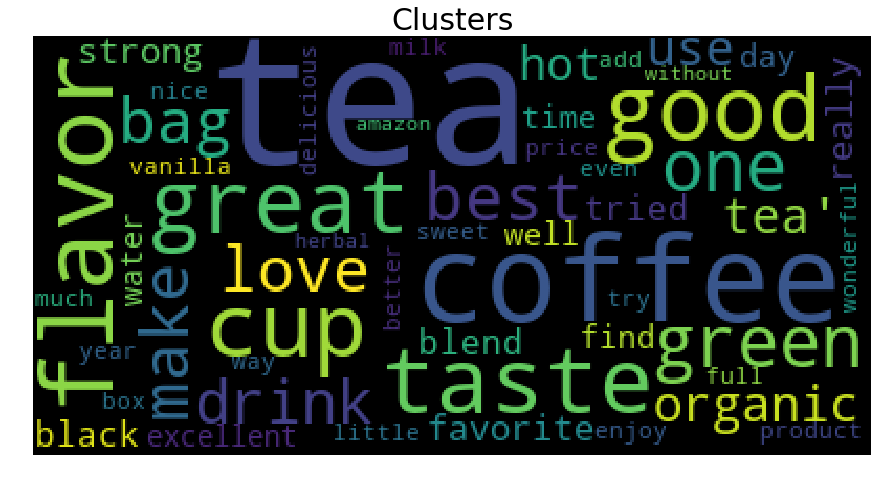

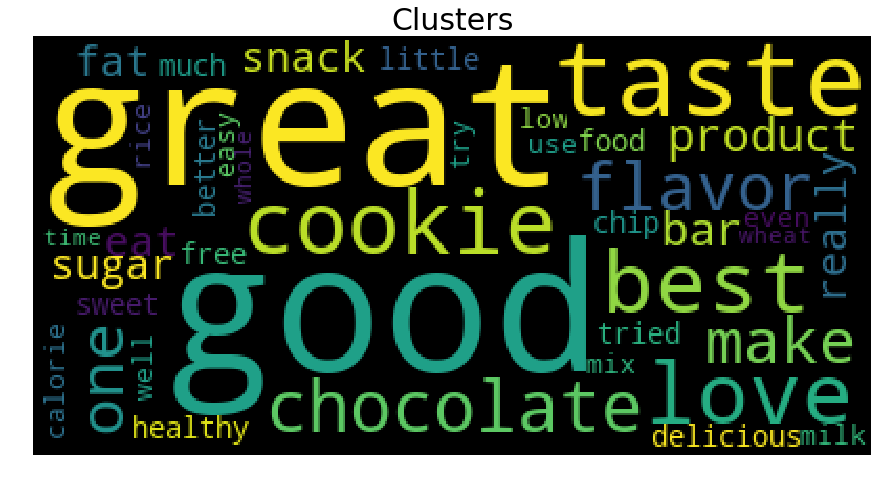

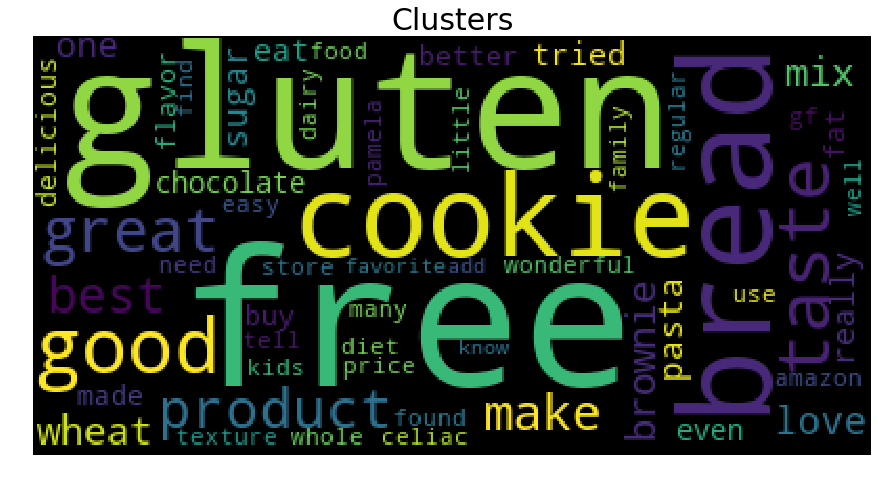

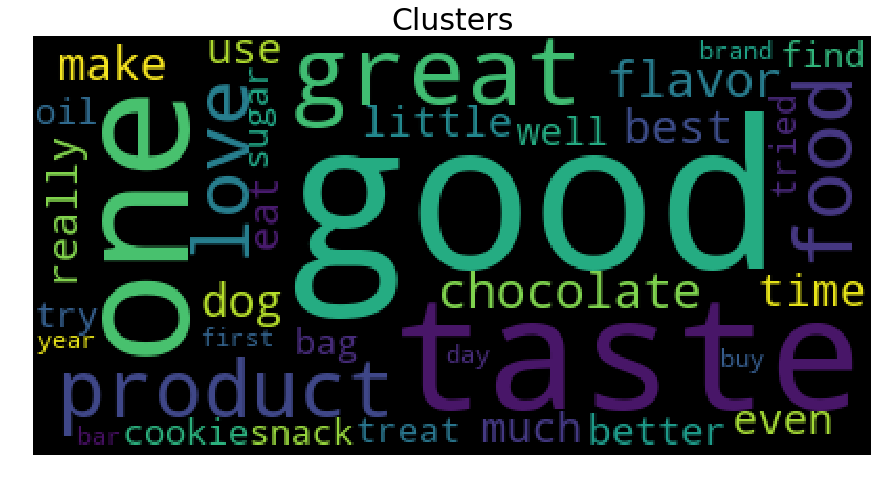

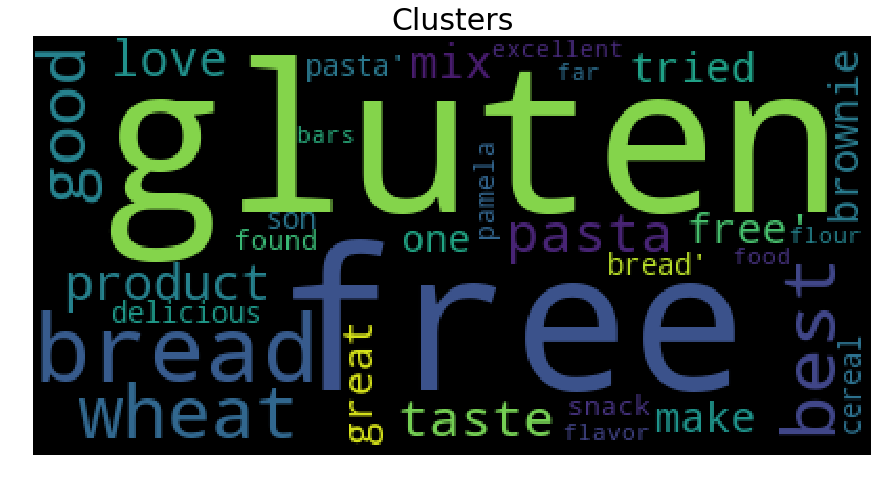

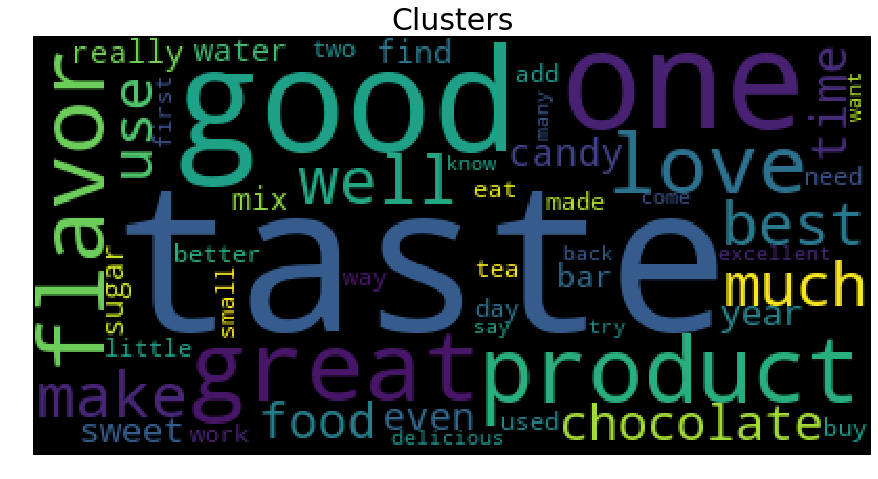

In [70]:
# Please write all the code with proper documentation
all_agg(3)
all_agg(5)
all_agg(7)

**Observation:**

<font color='blue'>**With 3 clusters:**</font>

The clusters are about,
1. This cluster is for product and the related words like 'great' 'good,'test.'
2. This cluster is about tea, coffee and related words.
3. This cluster is about related Gluten, 'cookie', 'bread', 'brownie' and product related words like how good or great it is.
 


<font color='blue'>**With 5 clusters:**</font>

The clusters are about,
1. This cluster is about related Gluten, 'cookie', 'bread', 'brownie' and product related words like how good or great it is.
2. This cluster is about product related words like good test, and great it is...
3. This cluster is about tea, coffee and flavour related words.
4. This cluster is about chocolate related words..
5. This cluster is about product related words like good test, and great it is and also the product price...


<font color='blue'>**With 7 clusters:**</font>

The clusters are about,
1. This cluster is about tea, coffee, flavour related words.
2. This cluster is about price and the product related words like good, test, and great it is...
3. This cluster is about chocolate related words.
4. This cluster is about related Gluten, 'cookie', 'bread', 'brownie' and product related words like how good or great it is
5. This cluster is about product related words like good test, and great it is....
6. This cluster is about related Gluten, 'cookie', 'bread', 'brownie' and product related words like how good or great it is.
7. This cluster is about product related words like good test, and great it is....

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [105]:
# Please write all the code with proper documentation

def all_agg(n_clust):
    print("Clustering",n_clust," Clusters\n")
    agglo = AgglomerativeClustering(n_clusters=n_clust)
    agglo.fit(tfidf_sent_vec)
    clusters = [ [] for i in range(n_clust)]   
    for i in range(agglo.labels_.shape[0]):
        clusters[agglo.labels_[i]].append(X[i])
    i = 1
    for cls in clusters:
        cloud(cls)

### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

Clustering 2  Clusters



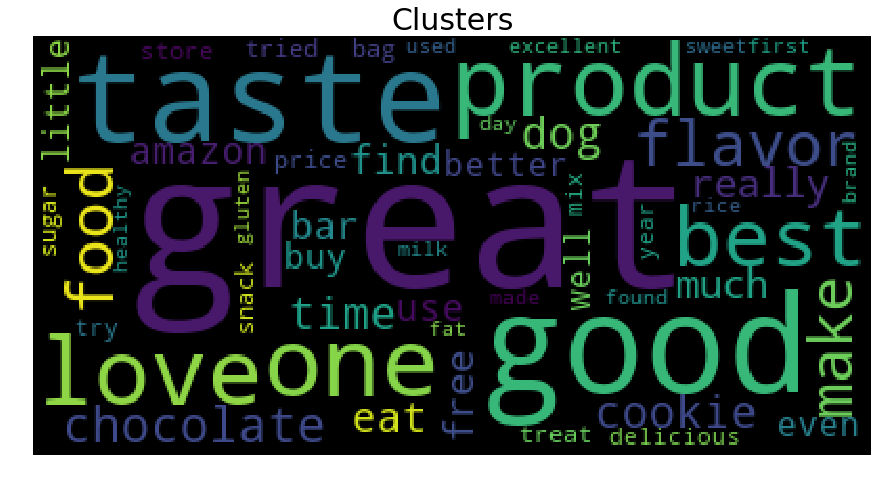

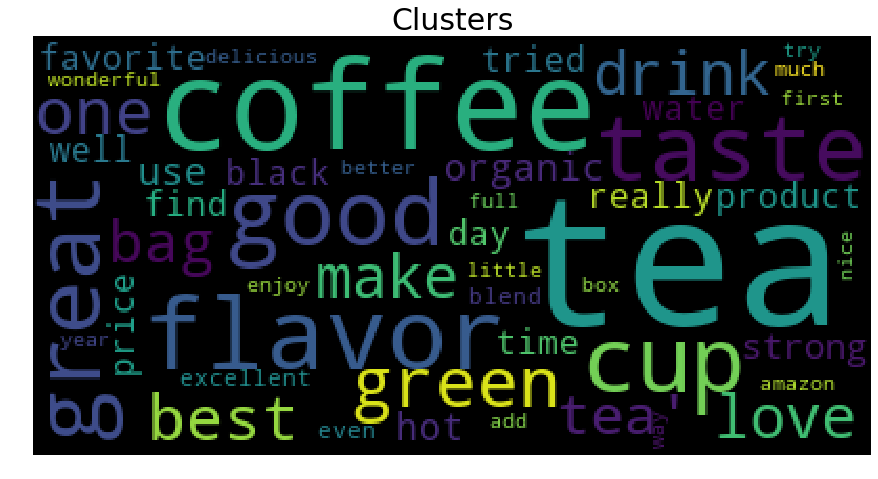

Clustering 3  Clusters



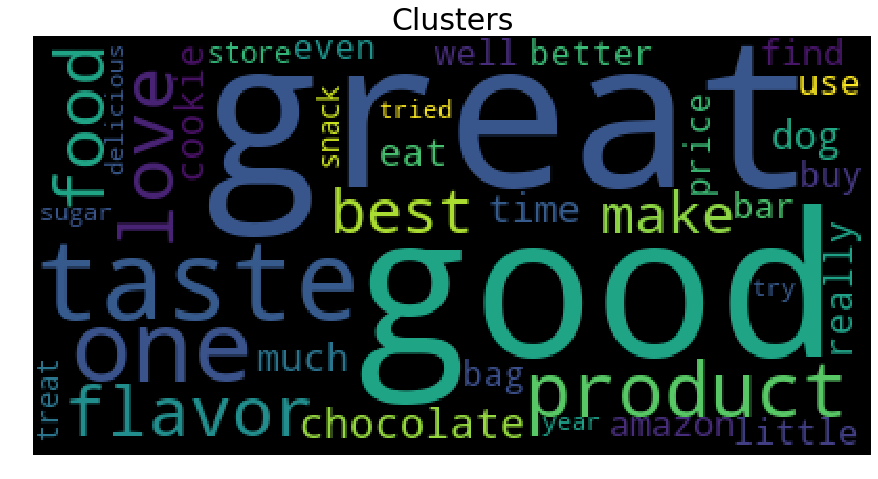

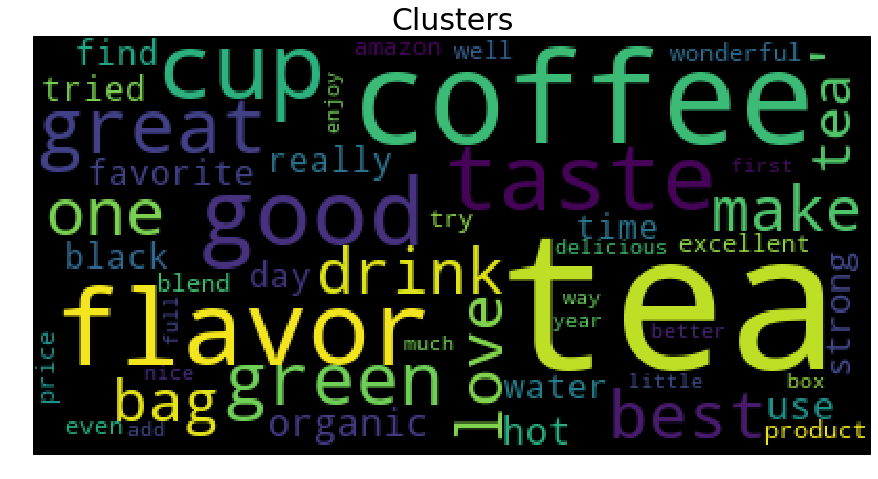

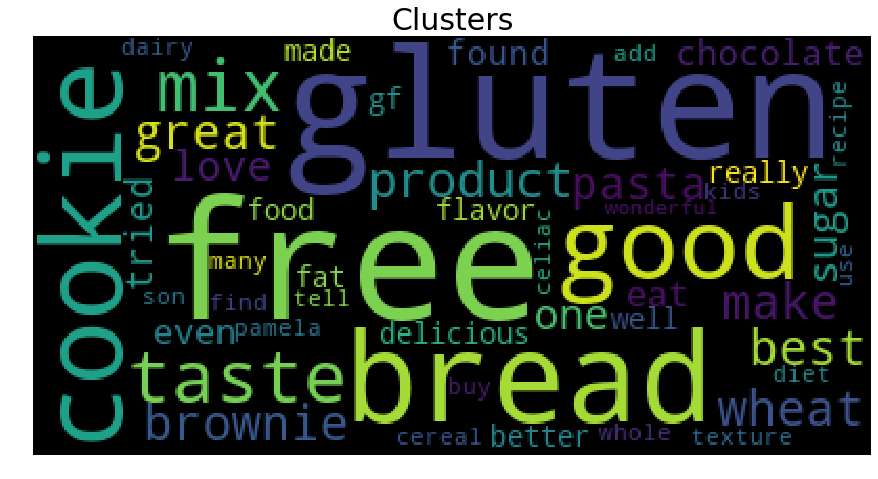

Clustering 5  Clusters



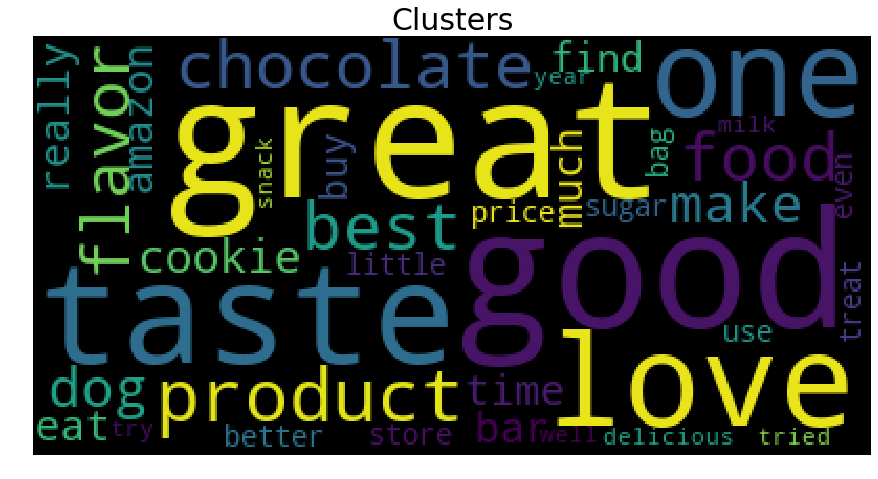

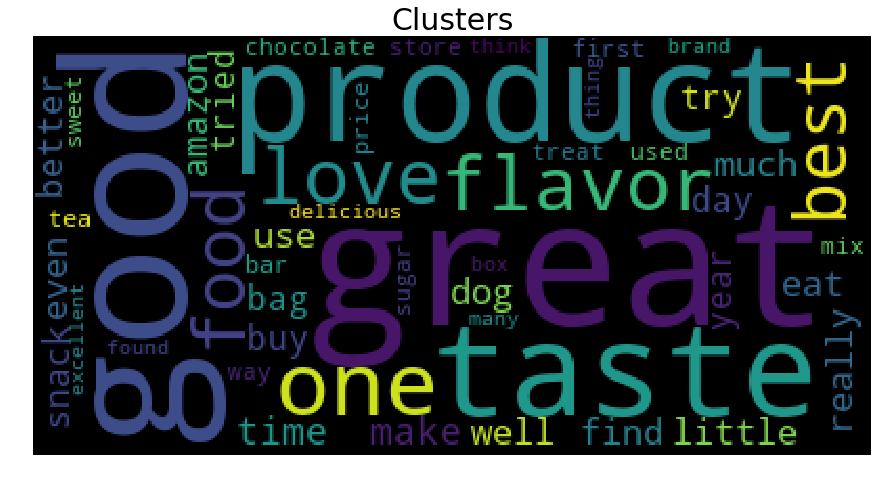

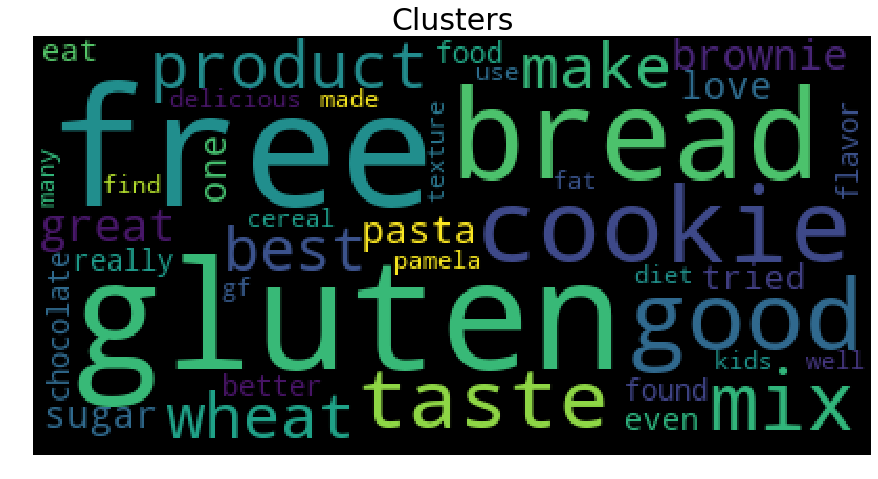

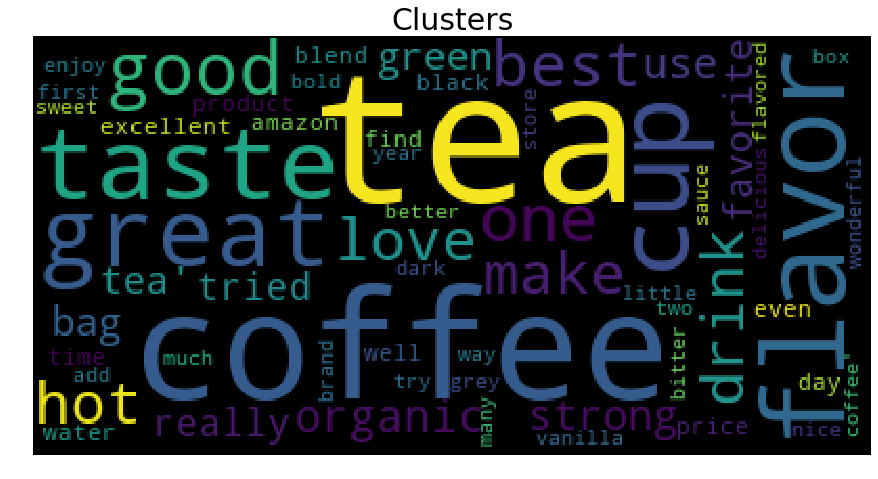

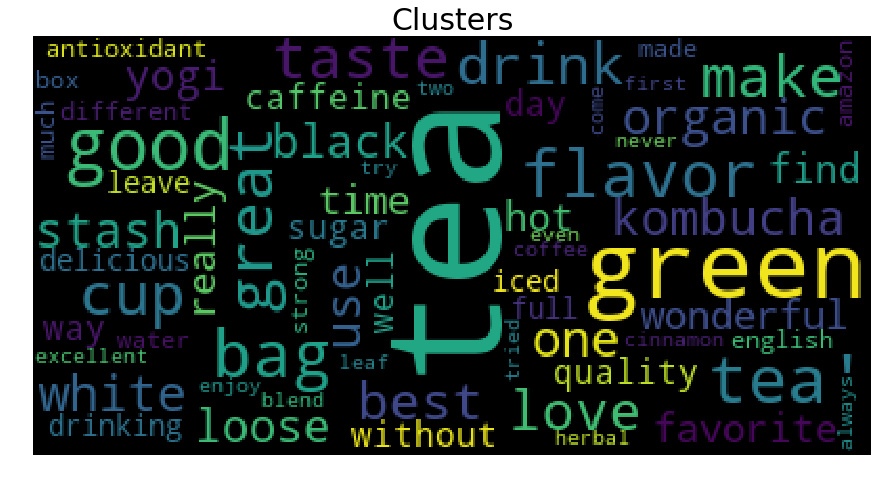

In [76]:
# Please write all the code with proper documentation
all_agg(2)
all_agg(3)
all_agg(5)

**Observation:**

<font color='blue'>**With 2 clusters:**</font>

The clusters are about,
1. This cluster is for product and the related words like 'great' 'good,'test.'
2. This cluster is about tea, coffee and related words.
 


<font color='blue'>**With 3 clusters:**</font>

The clusters are about,
1.  This cluster is about chocolate and how product is good and great it is..
2. This cluster is about tea, green tea, coffee and related words.
3. This cluster is about related Gluten, 'cookie', 'bread', 'brownie' and product related words like how good or great it is
 


<font color='blue'>**With 5 clusters:**</font>

The clusters are about,
1. This cluster is about chocolate and also how product related words like good test, and great it is....
2. This cluster is about product related words like good test, and great it is....
3. This cluster is about related Gluten, 'cookie', 'bread', 'brownie' and product related words like how good or great it is
4. This cluster is about tea, coffee and related words.
5. This cluster is about green tea, tea in general related words.

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

In [121]:
# Please write all the code with proper documentation
from sklearn.cluster import DBSCAN
def all_db(db,min_point):
     
    dist = []
    for x in tqdm(db):
        tmp = np.linalg.norm(db-x,axis=1)
        tmp = np.sort(tmp)
        dist.append(tmp[min_point])
    dist = np.sort(dist)
    plt.plot(dist)
    plt.grid(True)
    plt.ylabel("Distance")
    plt.title("eps Distances")
    plt.show()

100%|██████████| 5000/5000 [00:09<00:00, 551.47it/s]


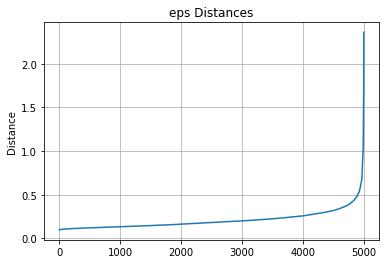

In [122]:
all_db(db=sent_vectors,min_point= 2*sent_vectors.shape[1])

### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

Epsilon Value =  0.5


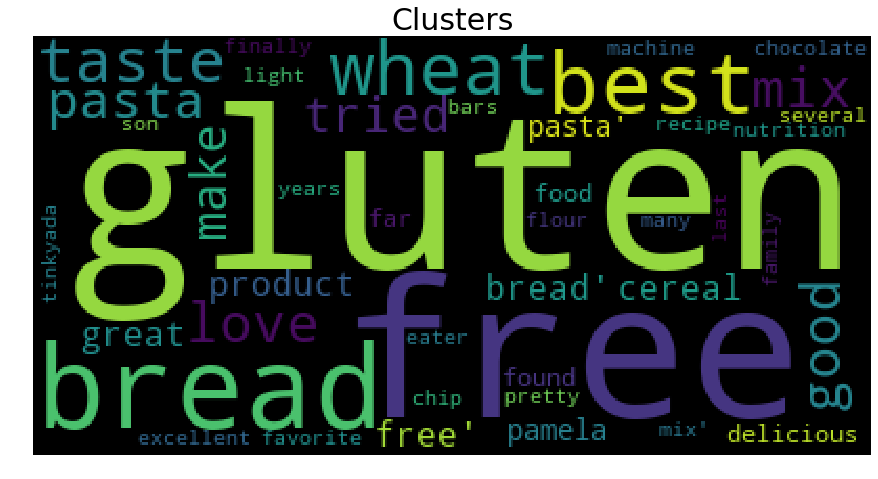

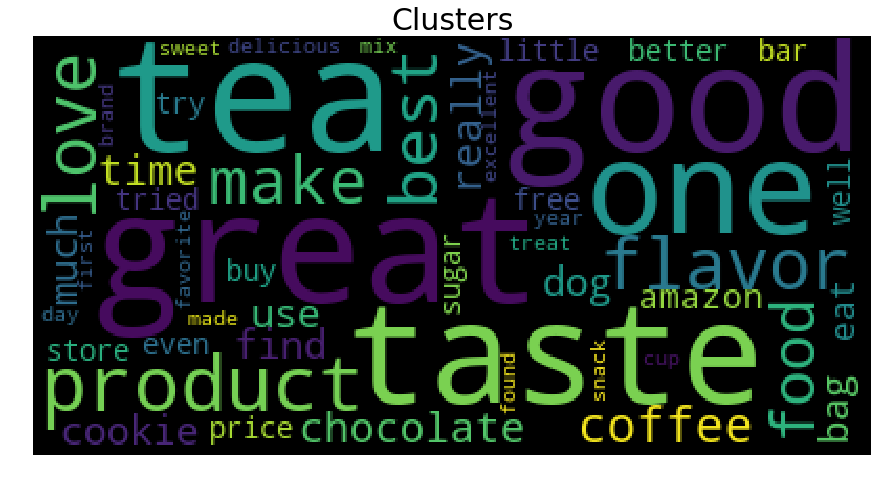

Epsilon Value =  0.6


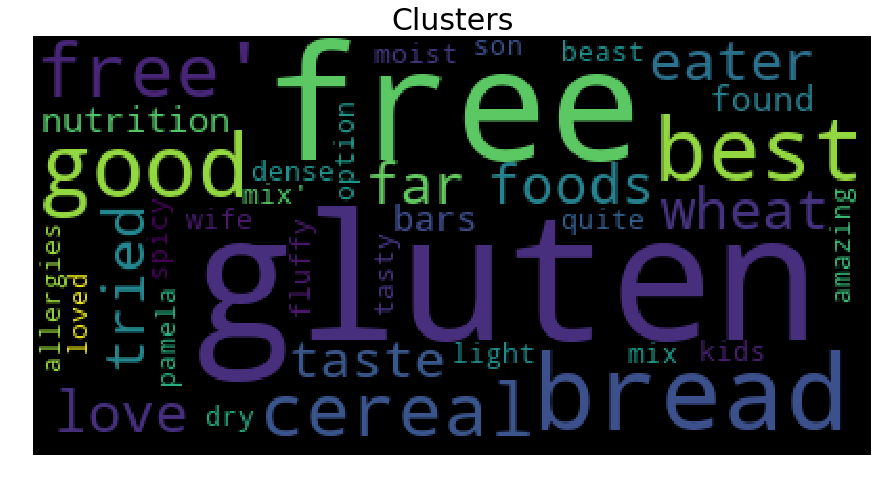

Epsilon Value =  0.7


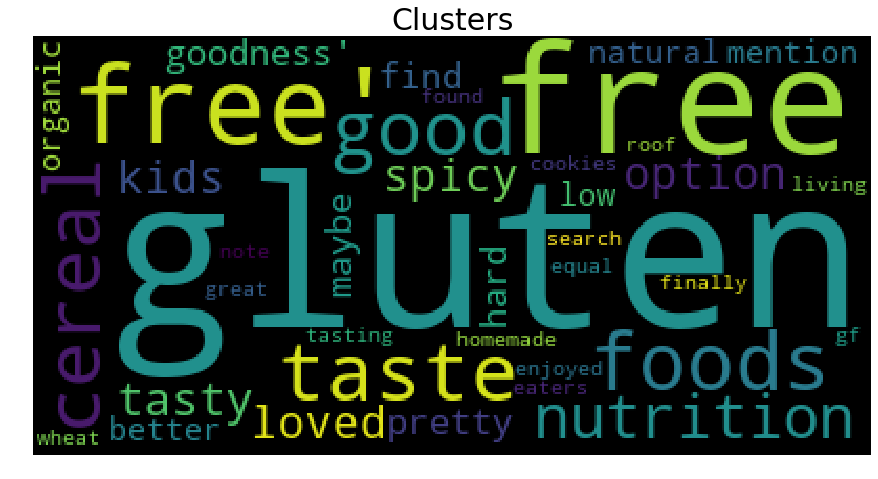

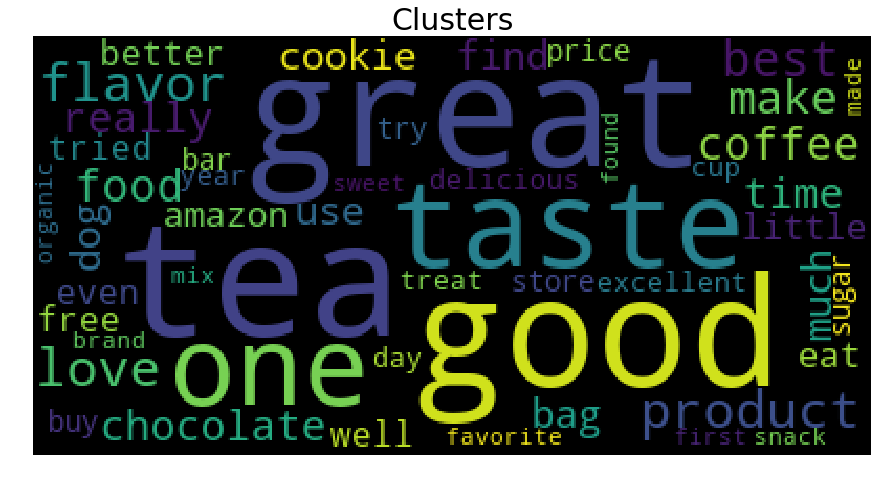

In [104]:
# Please write all the code with proper documentation

epsilon = [0.5,0.6,0.7]
for ep in epsilon:
    print("Epsilon Value = ",ep)
    db = DBSCAN(eps=ep, min_samples=2*sent_vectors.shape[1])
    db.fit(sent_vectors)
    labels = db.labels_ + 1 # to avoid -1 a for outliers
    clusters = [ [] for i in range(len(set(labels))) ]  # this is the list of clusters
    for i in range(labels.shape[0]):
        clusters[labels[i]].append(X[i])
    i = 1
    for cls in clusters:
        cloud(cls)

**Observation:**

<font color='blue'>**With eps = 0.5:**</font>
  
The clusters are about,
1. This cluster is about related Gluten, 'cookie', 'bread', 'brownie' and product related words like how good or great it is
2. This cluster is about tea, probably chocolate and price related words..


<font color='blue'>**With eps = 0.6:**</font>

The clusters are about,
1. This cluster is about related Gluten, 'cookie', 'bread', 'brownie' and product related words like how good or great it is
2. This cluster is about chocolate, tea and coffee related words..


<font color='blue'>**With eps = 0.7:**</font>

The clusters are about,
1. This cluster is about related Gluten, 'cookie', 'bread', 'brownie' and product related words like how good or great it is
2. This cluster is about tea, good, test, related words.

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

In [95]:
# Please write all the code with proper documentation

def all_db(db,min_point):
     
    dist = []
    for x in tqdm(db):
        tmp = np.linalg.norm(db-x,axis=1)
        tmp = np.sort(tmp)
        dist.append(tmp[min_point])
    dist = np.sort(dist)
    plt.plot(dist)
    plt.grid(True)
    plt.ylabel("Distance")
    plt.title("eps Distances")
    plt.show()

100%|██████████| 5000/5000 [00:10<00:00, 498.10it/s]


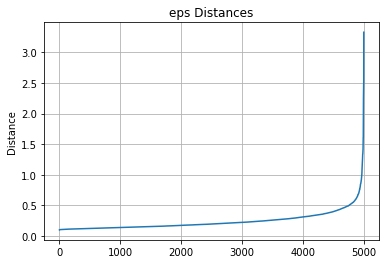

In [100]:
all_db(db=tfidf_sent_vec,min_point= 2*tfidf_sent_vec.shape[1])

### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

Epsilon Value =  0.5


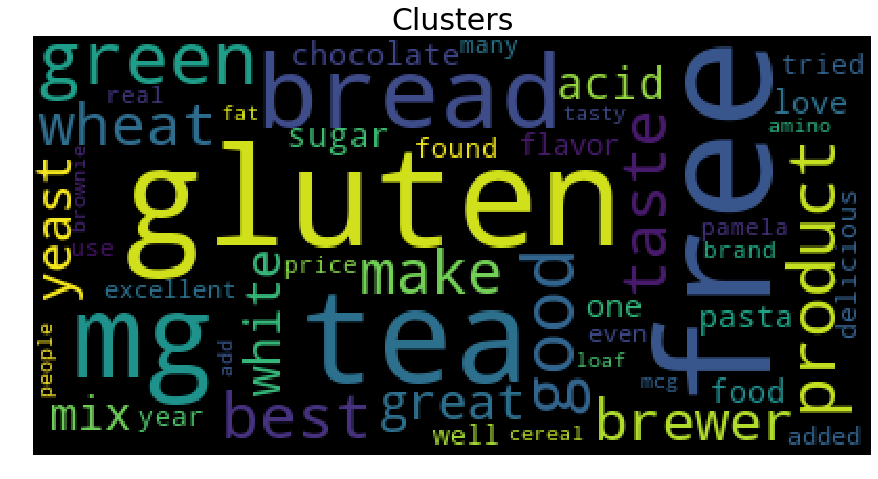

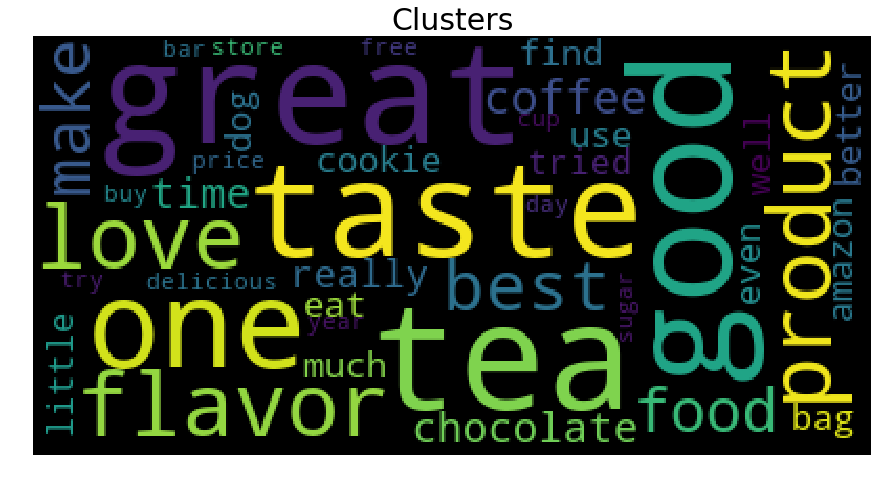

Epsilon Value =  0.6


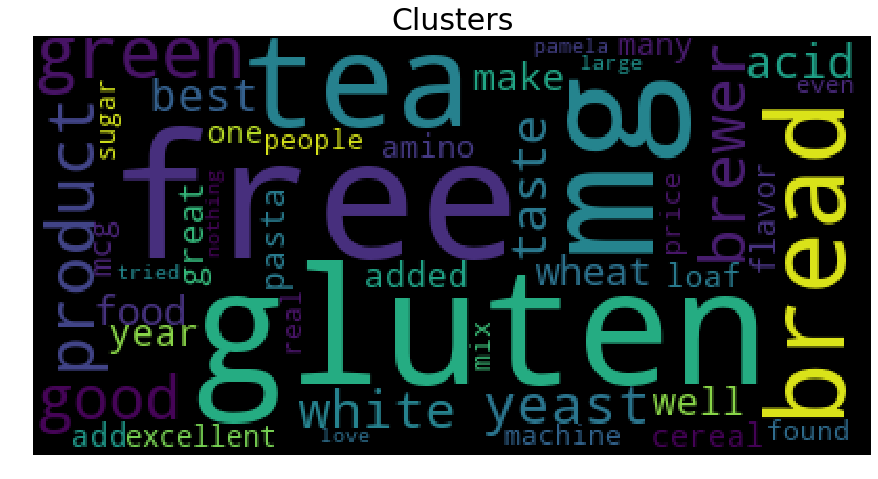

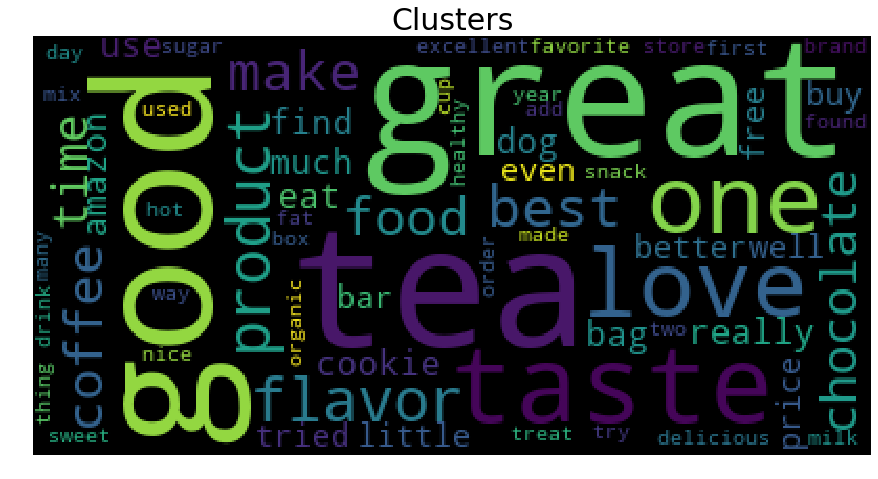

Epsilon Value =  0.7


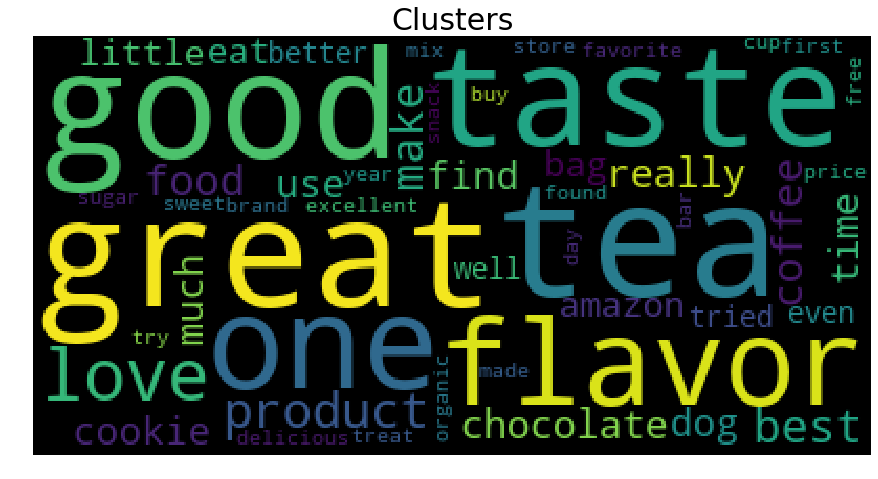

In [103]:
# Please write all the code with proper documentation
epsilon = [0.5,0.6,0.7]
for ep in epsilon:
    print("Epsilon Value = ",ep)
    db = DBSCAN(eps=ep, min_samples=2*tfidf_sent_vec.shape[1])
    db.fit(tfidf_sent_vec)
    labels = db.labels_ + 1 # to avoid -1 a for outliers
    clusters = [ [] for i in range(len(set(labels))) ]  # this is the list of clusters
    for i in range(labels.shape[0]):
        clusters[labels[i]].append(X[i])
    i = 1
    for cls in clusters:
        cloud(cls)      

**Observation:**

<font color='blue'>**With eps = 0.5:**</font>
  
The clusters are about,
1. This cluster is about related Gluten, 'cookie', 'bread', 'brownie' and product related words like how good or great it is
2. This cluster is test, good and tea related words..


<font color='blue'>**With eps = 0.6:**</font>

The clusters are about,
1. This cluster is about related Gluten, 'cookie', 'bread', 'brownie' and product related words like how good or great it is
2. This cluster is test and tea..


<font color='blue'>**With eps = 0.7:**</font>

The clusters are about,
1. This cluster is about related Gluten, 'cookie', 'bread', 'brownie' and product related words like how good or great it is
2. This cluster is about tea and chocolate and flavor related words..

# [6] Conclusions

In [108]:
# Please compare all your models using Prettytable library. 
 
from prettytable import PrettyTable

Vectorizer = ['Bag of Words','TFIDF','AVG W2V','TFIDF W2V']

kmeans=[7,7,7,7]

numbering = [1,2,3,4]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering) 
ptable.add_column("Vectorizers",Vectorizer)
 
ptable.add_column("Kmeans",kmeans)
 
print(ptable)

+-------+--------------+--------+
| S.NO. | Vectorizers  | Kmeans |
+-------+--------------+--------+
|   1   | Bag of Words |   7    |
|   2   |    TFIDF     |   7    |
|   3   |   AVG W2V    |   7    |
|   4   |  TFIDF W2V   |   7    |
+-------+--------------+--------+


In [112]:
Vectorizer = ['AVG W2V','TFIDF W2V']

agglo=[3, 2 ]

numbering = [1,2]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering) 
ptable.add_column("Vectorizers",Vectorizer)
 
ptable.add_column("Clusters",agglo)
 
print(ptable)

+-------+-------------+----------+
| S.NO. | Vectorizers | Clusters |
+-------+-------------+----------+
|   1   |   AVG W2V   |    3     |
|   2   |  TFIDF W2V  |    2     |
+-------+-------------+----------+


In [116]:
Vectorizer = ['AVG W2V','TFIDF W2V']

eps1=[0.5, 0.5]

numbering = [1,2]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering) 
ptable.add_column("Vectorizers",Vectorizer)
ptable.add_column("Eps",eps)
print(ptable)

+-------+-------------+-----+
| S.NO. | Vectorizers | Eps |
+-------+-------------+-----+
|   1   |   AVG W2V   | 0.5 |
|   2   |  TFIDF W2V  | 0.5 |
+-------+-------------+-----+
